# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-lc'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(least_confident_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8278, F1 Micro: 0.0483, F1 Macro: 0.017
Epoch 2/10, Train Loss: 0.4112, Accuracy: 0.8287, F1 Micro: 0.0251, F1 Macro: 0.0109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3817, Accuracy: 0.8313, F1 Micro: 0.0562, F1 Macro: 0.023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8534, F1 Micro: 0.3322, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3425, Accuracy: 0.8667, F1 Micro: 0.4499, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3131, Accuracy: 0.8731, F1 Micro: 0.6036, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2691, Accuracy: 0.8766, F1 Micro: 0.6219, F1 Macro: 0.3077
Epoch 8/10, Train Loss: 0.2634, Accuracy: 0.8822, F1 Micro: 0.5944, F1 Macro: 0.2945
Epoch 9/10, Train Loss: 0.2253, Accuracy: 0.8804, F1 Micro: 0.5629, F1 Macro: 0.2872
Epoch 10/10, Train Loss: 0.1952, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.8327, F1 Micro: 0.0738, F1 Macro: 0.0298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.861, F1 Micro: 0.4295, F1 Macro: 0.1869
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.8631, F1 Micro: 0.4217, F1 Macro: 0.1939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.8749, F1 Micro: 0.5856, F1 Macro: 0.295
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.8737, F1 Micro: 0.5214, F1 Macro: 0.2454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.8809, F1 Micro: 0.591, F1 Macro: 0.3136
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.8842, F1 Micro: 0.6318, F1 Macro: 0.3698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.8857, F1 Micro: 0.6438, F1 Macro: 0.379
Higher F1 achiev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.8388, F1 Micro: 0.1762, F1 Macro: 0.0728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.8623, F1 Micro: 0.4528, F1 Macro: 0.2003
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.8735, F1 Micro: 0.5656, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.879, F1 Micro: 0.5796, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.8788, F1 Micro: 0.6514, F1 Macro: 0.3649
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.8861, F1 Micro: 0.5995, F1 Macro: 0.2997
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.8876, F1 Micro: 0.6492, F1 Macro: 0.3615
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.8922, F1 Micro: 0.6518, F1 Macro: 0.3726
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.286, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1782, Accuracy: 0.8372, F1 Micro: 0.127, F1 Macro: 0.0506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1411, Accuracy: 0.8639, F1 Micro: 0.451, F1 Macro: 0.209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1185, Accuracy: 0.8727, F1 Micro: 0.6304, F1 Macro: 0.2951
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.8726, F1 Micro: 0.6554, F1 Macro: 0.35
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.889, F1 Micro: 0.6251, F1 Macro: 0.3229
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.8896, F1 Micro: 0.6361, F1 Macro: 0.4284
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.8963, F1 Micro: 0.6638, F1 Macro: 0.4321
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.8944, F1 Micro: 0.688, F1 Macro: 0.4552
Epoch 10/10, Train

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2709, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1788, Accuracy: 0.8416, F1 Micro: 0.1925, F1 Macro: 0.0893
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.8744, F1 Micro: 0.6171, F1 Macro: 0.3085
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1146, Accuracy: 0.8855, F1 Micro: 0.6573, F1 Macro: 0.3626
Epoch 5/10, Train Loss: 0.096, Accuracy: 0.8911, F1 Micro: 0.6503, F1 Macro: 0.3307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.8909, F1 Micro: 0.6946, F1 Macro: 0.4684
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.896, F1 Micro: 0.6568, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9004, F1 Micro: 0.7071, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9034, F1 Micro: 0.7128, F1 Macro: 0.4774
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2696, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1878, Accuracy: 0.8626, F1 Micro: 0.4753, F1 Macro: 0.216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.8806, F1 Micro: 0.6019, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1208, Accuracy: 0.8922, F1 Micro: 0.6711, F1 Macro: 0.3615
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.8965, F1 Micro: 0.6556, F1 Macro: 0.4137
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.8985, F1 Micro: 0.7011, F1 Macro: 0.4742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.8972, F1 Micro: 0.703, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9035, F1 Micro: 0.7044, F1 Macro: 0.4802
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.8996, F1 Micro: 0.6854, F1 Macro: 0.4692
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2775, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1947, Accuracy: 0.8779, F1 Micro: 0.5562, F1 Macro: 0.2788
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.8895, F1 Micro: 0.6813, F1 Macro: 0.3876
Epoch 4/10, Train Loss: 0.1166, Accuracy: 0.8989, F1 Micro: 0.6781, F1 Macro: 0.4042
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9041, F1 Micro: 0.7188, F1 Macro: 0.4911
Epoch 6/10, Train Loss: 0.0729, Accuracy: 0.9076, F1 Micro: 0.702, F1 Macro: 0.4862
Epoch 7/10, Train Loss: 0.0582, Accuracy: 0.9012, F1 Micro: 0.7167, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9055, F1 Micro: 0.7235, F1 Macro: 0.5123
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9048, F1 Micro: 0.7279, F1 Macro: 0.5103
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2899, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.8823, F1 Micro: 0.5717, F1 Macro: 0.3595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9015, F1 Micro: 0.6862, F1 Macro: 0.4207
Epoch 4/10, Train Loss: 0.118, Accuracy: 0.9056, F1 Micro: 0.6777, F1 Macro: 0.4494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0948, Accuracy: 0.9088, F1 Micro: 0.7197, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.9097, F1 Micro: 0.7372, F1 Macro: 0.5579
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9139, F1 Micro: 0.7363, F1 Macro: 0.5639
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9111, F1 Micro: 0.7335, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9111, F1 Micro: 0.7384, F1 Macro: 0.5698
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3017, Accuracy: 0.8397, F1 Micro: 0.153, F1 Macro: 0.0667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2043, Accuracy: 0.8934, F1 Micro: 0.6122, F1 Macro: 0.3663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9071, F1 Micro: 0.69, F1 Macro: 0.4953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9096, F1 Micro: 0.7367, F1 Macro: 0.5651
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.9126, F1 Micro: 0.7226, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9175, F1 Micro: 0.7527, F1 Macro: 0.5815
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9106, F1 Micro: 0.7235, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9163, F1 Micro: 0.7532, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9167, F1 Micro: 0.7606, F1 Macro: 0.6068
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3111, Accuracy: 0.8508, F1 Micro: 0.275, F1 Macro: 0.1296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2108, Accuracy: 0.8667, F1 Micro: 0.3921, F1 Macro: 0.2396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9101, F1 Micro: 0.7145, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1214, Accuracy: 0.9097, F1 Micro: 0.7468, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.916, F1 Micro: 0.7489, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9168, F1 Micro: 0.7571, F1 Macro: 0.5985
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9181, F1 Micro: 0.7557, F1 Macro: 0.6079
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9179, F1 Micro: 0.7558, F1 Macro: 0.615
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9184, F1 Micro: 0.7552, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3109, Accuracy: 0.87, F1 Micro: 0.4447, F1 Macro: 0.2293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2064, Accuracy: 0.9017, F1 Micro: 0.6753, F1 Macro: 0.5316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9143, F1 Micro: 0.7266, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9178, F1 Micro: 0.747, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0929, Accuracy: 0.9185, F1 Micro: 0.7584, F1 Macro: 0.6009
Epoch 6/10, Train Loss: 0.0776, Accuracy: 0.9184, F1 Micro: 0.7532, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9211, F1 Micro: 0.7637, F1 Macro: 0.614
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9181, F1 Micro: 0.7602, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9164, F1 Micro: 0.7663, F1 Macro: 0.6252
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3324, Accuracy: 0.8832, F1 Micro: 0.587, F1 Macro: 0.4072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9032, F1 Micro: 0.6547, F1 Macro: 0.4928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9183, F1 Micro: 0.7396, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9159, F1 Micro: 0.7579, F1 Macro: 0.6148
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.9194, F1 Micro: 0.7539, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9218, F1 Micro: 0.7682, F1 Macro: 0.6198
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9219, F1 Micro: 0.767, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9256, F1 Micro: 0.7788, F1 Macro: 0.6333
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9189, F1 Micro: 0.7718, F1 Macro: 0.631
Epoch 10/10, Train Loss: 0.0409, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3232, Accuracy: 0.8812, F1 Micro: 0.5449, F1 Macro: 0.2814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2098, Accuracy: 0.914, F1 Micro: 0.7337, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9194, F1 Micro: 0.7542, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9211, F1 Micro: 0.7631, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9211, F1 Micro: 0.7704, F1 Macro: 0.6197
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9166, F1 Micro: 0.7682, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9231, F1 Micro: 0.773, F1 Macro: 0.6324
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9222, F1 Micro: 0.7687, F1 Macro: 0.6238
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9201, F1 Micro: 0.7711, F1 Macro: 0.6326
Epoch 10/10, Train Loss: 0.0376, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.8897, F1 Micro: 0.6323, F1 Macro: 0.4065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.211, Accuracy: 0.9131, F1 Micro: 0.7166, F1 Macro: 0.5386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9201, F1 Micro: 0.7587, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9224, F1 Micro: 0.7647, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0994, Accuracy: 0.9213, F1 Micro: 0.7722, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.925, F1 Micro: 0.778, F1 Macro: 0.6323
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9185, F1 Micro: 0.7594, F1 Macro: 0.6179
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9173, F1 Micro: 0.7643, F1 Macro: 0.6278
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9211, F1 Micro: 0.7643, F1 Macro: 0.6285
Epoch 10/10, Train Loss: 0.0395, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3246, Accuracy: 0.8935, F1 Micro: 0.655, F1 Macro: 0.4829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2148, Accuracy: 0.9113, F1 Micro: 0.6969, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9214, F1 Micro: 0.7631, F1 Macro: 0.6047
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9198, F1 Micro: 0.7509, F1 Macro: 0.5684
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.9248, F1 Micro: 0.7619, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9252, F1 Micro: 0.7786, F1 Macro: 0.6369
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9231, F1 Micro: 0.7722, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9236, F1 Micro: 0.7803, F1 Macro: 0.6393
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9201, F1 Micro: 0.7711, F1 Macro: 0.6374
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9228, F1 Micro: 0.7751, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.8991, F1 Micro: 0.662, F1 Macro: 0.4408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.21, Accuracy: 0.9159, F1 Micro: 0.735, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9222, F1 Micro: 0.7627, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1316, Accuracy: 0.923, F1 Micro: 0.7662, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1037, Accuracy: 0.924, F1 Micro: 0.7715, F1 Macro: 0.6156
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9224, F1 Micro: 0.7714, F1 Macro: 0.6271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9246, F1 Micro: 0.7802, F1 Macro: 0.6441
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9239, F1 Micro: 0.7795, F1 Macro: 0.6473
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9217, F1 Micro: 0.7758, F1 Macro: 0.6387
Epoch 10/10, Train Loss: 0.0425, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.9005, F1 Micro: 0.6751, F1 Macro: 0.4304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.915, F1 Micro: 0.7261, F1 Macro: 0.544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9179, F1 Micro: 0.7464, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9243, F1 Micro: 0.7769, F1 Macro: 0.6275
Epoch 5/10, Train Loss: 0.1006, Accuracy: 0.9246, F1 Micro: 0.7732, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9219, F1 Micro: 0.7795, F1 Macro: 0.6362
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9216, F1 Micro: 0.7713, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9273, F1 Micro: 0.785, F1 Macro: 0.6358
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9231, F1 Micro: 0.7816, F1 Macro: 0.6491
Epoch 10/10, Train Loss: 0.0402, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3257, Accuracy: 0.8984, F1 Micro: 0.6599, F1 Macro: 0.4872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9158, F1 Micro: 0.7494, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9214, F1 Micro: 0.7736, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9221, F1 Micro: 0.7786, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1042, Accuracy: 0.9243, F1 Micro: 0.7793, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9263, F1 Micro: 0.7836, F1 Macro: 0.6335
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9259, F1 Micro: 0.7824, F1 Macro: 0.6424
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9243, F1 Micro: 0.7683, F1 Macro: 0.6357
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9224, F1 Micro: 0.7736, F1 Macro: 0.656
Epoch 10/10, Train Loss: 0.0434, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.9027, F1 Micro: 0.7091, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2101, Accuracy: 0.9177, F1 Micro: 0.7494, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.919, F1 Micro: 0.7648, F1 Macro: 0.5922
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.9234, F1 Micro: 0.7629, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9259, F1 Micro: 0.7824, F1 Macro: 0.6409
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.924, F1 Micro: 0.7791, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9261, F1 Micro: 0.7838, F1 Macro: 0.6493
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9264, F1 Micro: 0.7812, F1 Macro: 0.6635
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9216, F1 Micro: 0.7766, F1 Macro: 0.6547
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.926, F1 Micro: 0.7815, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.9046, F1 Micro: 0.6852, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.21, Accuracy: 0.918, F1 Micro: 0.7338, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9251, F1 Micro: 0.7741, F1 Macro: 0.6192
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.9219, F1 Micro: 0.7613, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9273, F1 Micro: 0.785, F1 Macro: 0.6359
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9218, F1 Micro: 0.7763, F1 Macro: 0.6371
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9266, F1 Micro: 0.7862, F1 Macro: 0.6626
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9251, F1 Micro: 0.7779, F1 Macro: 0.6503
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9263, F1 Micro: 0.778, F1 Macro: 0.6561
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9237, F1 Micro: 0.7707, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.8977, F1 Micro: 0.709, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2126, Accuracy: 0.9153, F1 Micro: 0.7499, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9209, F1 Micro: 0.7614, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1311, Accuracy: 0.9197, F1 Micro: 0.7729, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9261, F1 Micro: 0.7814, F1 Macro: 0.6321
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9244, F1 Micro: 0.7735, F1 Macro: 0.6181
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9227, F1 Micro: 0.7796, F1 Macro: 0.6445
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.921, F1 Micro: 0.7775, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9272, F1 Micro: 0.7843, F1 Macro: 0.6727
Epoch 10/10, Train Loss: 0.0422, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9035, F1 Micro: 0.7106, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2072, Accuracy: 0.9189, F1 Micro: 0.745, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9233, F1 Micro: 0.7505, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.9241, F1 Micro: 0.7763, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9288, F1 Micro: 0.7869, F1 Macro: 0.6531
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.924, F1 Micro: 0.7747, F1 Macro: 0.645
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9263, F1 Micro: 0.7825, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9278, F1 Micro: 0.7886, F1 Macro: 0.6637
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9266, F1 Micro: 0.7792, F1 Macro: 0.6589
Epoch 10/10, Train Loss: 0.0409, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.904, F1 Micro: 0.6826, F1 Macro: 0.475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2121, Accuracy: 0.92, F1 Micro: 0.7537, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.9238, F1 Micro: 0.7809, F1 Macro: 0.6304
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.9257, F1 Micro: 0.7756, F1 Macro: 0.637
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9264, F1 Micro: 0.7793, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9264, F1 Micro: 0.7839, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9273, F1 Micro: 0.7856, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9244, F1 Micro: 0.7844, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9236, F1 Micro: 0.774, F1 Macro: 0.6598
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9264, F1 Micro: 0.7815, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3227, Accuracy: 0.904, F1 Micro: 0.6885, F1 Macro: 0.47
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9199, F1 Micro: 0.7408, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.925, F1 Micro: 0.7822, F1 Macro: 0.6497
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9264, F1 Micro: 0.7771, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9236, F1 Micro: 0.7811, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9265, F1 Micro: 0.7877, F1 Macro: 0.6585
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9253, F1 Micro: 0.7828, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9288, F1 Micro: 0.7893, F1 Macro: 0.6882
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9278, F1 Micro: 0.7829, F1 Macro: 0.6768
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0.928, F1 Micro: 0.7859, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.33, Accuracy: 0.9063, F1 Micro: 0.69, F1 Macro: 0.4777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.9202, F1 Micro: 0.7562, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9253, F1 Micro: 0.7832, F1 Macro: 0.6381
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9284, F1 Micro: 0.7818, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9278, F1 Micro: 0.7915, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9278, F1 Micro: 0.7748, F1 Macro: 0.6669
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9289, F1 Micro: 0.7871, F1 Macro: 0.6599
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.928, F1 Micro: 0.7838, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9251, F1 Micro: 0.7875, F1 Macro: 0.6928
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9263, F1 Micro: 0.7866, F1 Macro: 0.6891
Iteration 10018: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3269, Accuracy: 0.9031, F1 Micro: 0.7003, F1 Macro: 0.4392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2168, Accuracy: 0.9201, F1 Micro: 0.7487, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9271, F1 Micro: 0.7748, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9279, F1 Micro: 0.7899, F1 Macro: 0.6643
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.929, F1 Micro: 0.7784, F1 Macro: 0.6815
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9264, F1 Micro: 0.787, F1 Macro: 0.665
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9258, F1 Micro: 0.7846, F1 Macro: 0.6963
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9268, F1 Micro: 0.7849, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.928, F1 Micro: 0.7901, F1 Macro: 0.7134
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9249, F1 Micro: 0.7833, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.9035, F1 Micro: 0.6832, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.92, F1 Micro: 0.7474, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9238, F1 Micro: 0.7764, F1 Macro: 0.6319
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9258, F1 Micro: 0.7751, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9268, F1 Micro: 0.7854, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9278, F1 Micro: 0.7907, F1 Macro: 0.7083
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9283, F1 Micro: 0.7846, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9242, F1 Micro: 0.7816, F1 Macro: 0.7184
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.925, F1 Micro: 0.7837, F1 Macro: 0.7234
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.9242, F1 Micro: 0.7808, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9026, F1 Micro: 0.6564, F1 Macro: 0.4481
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9175, F1 Micro: 0.7535, F1 Macro: 0.5578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9221, F1 Micro: 0.7827, F1 Macro: 0.6732
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9276, F1 Micro: 0.779, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9256, F1 Micro: 0.7863, F1 Macro: 0.6805
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9291, F1 Micro: 0.7846, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9271, F1 Micro: 0.7899, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9259, F1 Micro: 0.79, F1 Macro: 0.7116
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9275, F1 Micro: 0.7898, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.0382, Accuracy

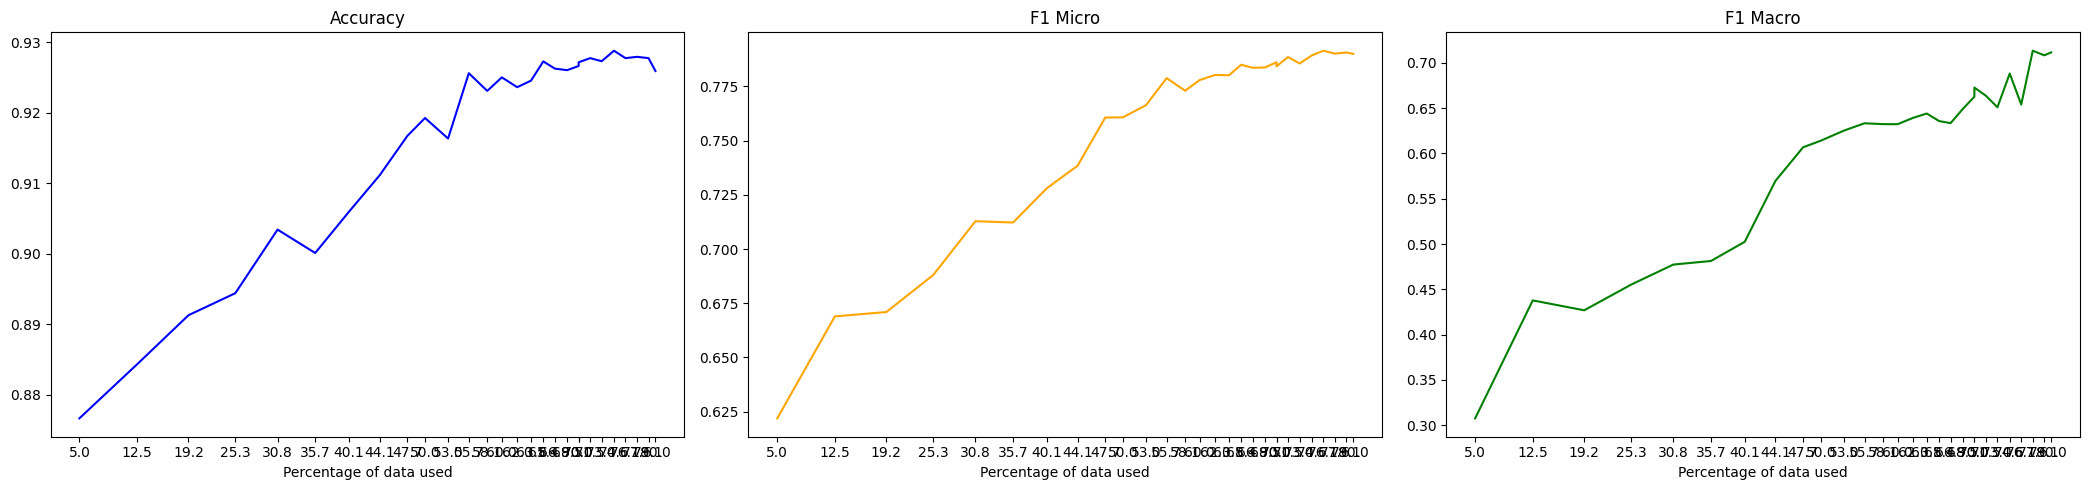

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.8301, F1 Micro: 0.2873, F1 Macro: 0.0657
Epoch 2/10, Train Loss: 0.3962, Accuracy: 0.836, F1 Micro: 0.144, F1 Macro: 0.0516
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8477, F1 Micro: 0.2738, F1 Macro: 0.0968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.342, Accuracy: 0.8656, F1 Micro: 0.4801, F1 Macro: 0.2063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3117, Accuracy: 0.8768, F1 Micro: 0.5736, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2746, Accuracy: 0.88, F1 Micro: 0.5854, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2515, Accuracy: 0.8841, F1 Micro: 0.5877, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2305, Accuracy: 0.8869, F1 Micro: 0.6337, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2015, Accuracy: 0.8891, F1 Micro: 0.6409, F1 Macro: 0.3499
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2355, Accuracy: 0.839, F1 Micro: 0.2104, F1 Macro: 0.073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.8686, F1 Micro: 0.5418, F1 Macro: 0.2454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.8763, F1 Micro: 0.5899, F1 Macro: 0.275
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.8682, F1 Micro: 0.4479, F1 Macro: 0.2039
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.8776, F1 Micro: 0.5317, F1 Macro: 0.2455
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.8882, F1 Micro: 0.626, F1 Macro: 0.3104
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.891, F1 Micro: 0.6565, F1 Macro: 0.3903
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.8925, F1 Micro: 0.6571, F1 Macro: 0.3754
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3038, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.187, Accuracy: 0.8429, F1 Micro: 0.2244, F1 Macro: 0.0795
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.8671, F1 Micro: 0.5076, F1 Macro: 0.2279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.8734, F1 Micro: 0.5195, F1 Macro: 0.234
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.8815, F1 Micro: 0.6153, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.8797, F1 Micro: 0.6581, F1 Macro: 0.3414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.8804, F1 Micro: 0.6646, F1 Macro: 0.3712
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.8885, F1 Micro: 0.6441, F1 Macro: 0.3906
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.8906, F1 Micro: 0.6431, F1 Macro: 0.3734
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2794, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.85, F1 Micro: 0.2731, F1 Macro: 0.1121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1259, Accuracy: 0.878, F1 Micro: 0.6172, F1 Macro: 0.2859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1088, Accuracy: 0.8782, F1 Micro: 0.65, F1 Macro: 0.3298
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.8876, F1 Micro: 0.6316, F1 Macro: 0.3121
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0732, Accuracy: 0.8913, F1 Micro: 0.6742, F1 Macro: 0.3704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.8948, F1 Micro: 0.681, F1 Macro: 0.4179
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.8951, F1 Micro: 0.6485, F1 Macro: 0.3491
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.8936, F1 Micro: 0.6724, F1 Macro: 0.4152
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8908

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2643, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.176, Accuracy: 0.8514, F1 Micro: 0.283, F1 Macro: 0.1055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.8823, F1 Micro: 0.612, F1 Macro: 0.2856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.8816, F1 Micro: 0.654, F1 Macro: 0.3123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.8919, F1 Micro: 0.673, F1 Macro: 0.3434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9008, F1 Micro: 0.6828, F1 Macro: 0.3946
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.8986, F1 Micro: 0.6917, F1 Macro: 0.4439
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.904, F1 Micro: 0.6844, F1 Macro: 0.4491
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.8999, F1 Micro: 0.6898, F1 Macro: 0.4699
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2633, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.8613, F1 Micro: 0.384, F1 Macro: 0.171
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.8876, F1 Micro: 0.6212, F1 Macro: 0.2993
Epoch 4/10, Train Loss: 0.1136, Accuracy: 0.8893, F1 Micro: 0.6033, F1 Macro: 0.3153
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0908, Accuracy: 0.9018, F1 Micro: 0.6851, F1 Macro: 0.4635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0737, Accuracy: 0.8998, F1 Micro: 0.7017, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.8995, F1 Micro: 0.7094, F1 Macro: 0.4841
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.8984, F1 Micro: 0.7092, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9065, F1 Micro: 0.7114, F1 Macro: 0.5164
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2658, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1886, Accuracy: 0.8555, F1 Micro: 0.3346, F1 Macro: 0.1579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1501, Accuracy: 0.8892, F1 Micro: 0.609, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1188, Accuracy: 0.8978, F1 Micro: 0.6899, F1 Macro: 0.3788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0875, Accuracy: 0.9052, F1 Micro: 0.7002, F1 Macro: 0.4363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9047, F1 Micro: 0.711, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9086, F1 Micro: 0.7222, F1 Macro: 0.5005
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9076, F1 Micro: 0.7261, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0434,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2795, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2008, Accuracy: 0.8893, F1 Micro: 0.6427, F1 Macro: 0.3277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.8992, F1 Micro: 0.6778, F1 Macro: 0.3751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.9047, F1 Micro: 0.7224, F1 Macro: 0.4964
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.902, F1 Micro: 0.7069, F1 Macro: 0.4207
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.9064, F1 Micro: 0.7291, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9111, F1 Micro: 0.7353, F1 Macro: 0.544
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.911, F1 Micro: 0.7345, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9149, F1 Micro: 0.7462, F1 Macro: 0.5487
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2911, Accuracy: 0.8475, F1 Micro: 0.2475, F1 Macro: 0.1151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1975, Accuracy: 0.897, F1 Micro: 0.6542, F1 Macro: 0.3755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9071, F1 Micro: 0.7092, F1 Macro: 0.4748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1254, Accuracy: 0.9102, F1 Micro: 0.7331, F1 Macro: 0.5492
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9131, F1 Micro: 0.7211, F1 Macro: 0.5296
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9126, F1 Micro: 0.7367, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9125, F1 Micro: 0.7469, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9164, F1 Micro: 0.7478, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9159, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2946, Accuracy: 0.8581, F1 Micro: 0.3639, F1 Macro: 0.1766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2024, Accuracy: 0.8997, F1 Micro: 0.6832, F1 Macro: 0.4506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9045, F1 Micro: 0.6834, F1 Macro: 0.3991
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1218, Accuracy: 0.912, F1 Micro: 0.7112, F1 Macro: 0.5345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9113, F1 Micro: 0.7448, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9153, F1 Micro: 0.7491, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.916, F1 Micro: 0.7556, F1 Macro: 0.5983
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9147, F1 Micro: 0.7514, F1 Macro: 0.5967
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9195, F1 Micro: 0.7545, F1 Macro: 0.5897
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2999, Accuracy: 0.8758, F1 Micro: 0.506, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9009, F1 Micro: 0.6474, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.9162, F1 Micro: 0.7457, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1209, Accuracy: 0.9129, F1 Micro: 0.7538, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0923, Accuracy: 0.9205, F1 Micro: 0.7577, F1 Macro: 0.6043
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9128, F1 Micro: 0.7478, F1 Macro: 0.5994
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9183, F1 Micro: 0.745, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9209, F1 Micro: 0.7621, F1 Macro: 0.6079
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9195, F1 Micro: 0.7528, F1 Macro: 0.6039
Epoch 10/10, Train Loss: 0.0343, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3155, Accuracy: 0.8821, F1 Micro: 0.5521, F1 Macro: 0.3111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2079, Accuracy: 0.9072, F1 Micro: 0.6939, F1 Macro: 0.5268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9181, F1 Micro: 0.7503, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1242, Accuracy: 0.9192, F1 Micro: 0.7545, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.9149, F1 Micro: 0.7575, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9156, F1 Micro: 0.7631, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9213, F1 Micro: 0.7671, F1 Macro: 0.6106
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9189, F1 Micro: 0.7681, F1 Macro: 0.6172
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.92, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.318, Accuracy: 0.8786, F1 Micro: 0.5162, F1 Macro: 0.3181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9102, F1 Micro: 0.7155, F1 Macro: 0.5711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9188, F1 Micro: 0.7505, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.917, F1 Micro: 0.7556, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9239, F1 Micro: 0.7752, F1 Macro: 0.6239
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9247, F1 Micro: 0.7683, F1 Macro: 0.6223
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9173, F1 Micro: 0.7682, F1 Macro: 0.6112
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9247, F1 Micro: 0.7693, F1 Macro: 0.6254
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9241, F1 Micro: 0.7702, F1 Macro: 0.6344
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9199, F1 Micro: 0.7654, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.319, Accuracy: 0.8938, F1 Micro: 0.6404, F1 Macro: 0.4391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.9128, F1 Micro: 0.7279, F1 Macro: 0.5351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9201, F1 Micro: 0.7557, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1287, Accuracy: 0.9217, F1 Micro: 0.7608, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9229, F1 Micro: 0.7726, F1 Macro: 0.6121
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9238, F1 Micro: 0.7707, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9228, F1 Micro: 0.7727, F1 Macro: 0.6159
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9203, F1 Micro: 0.77, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9223, F1 Micro: 0.7746, F1 Macro: 0.6284
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3223, Accuracy: 0.8921, F1 Micro: 0.622, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.9144, F1 Micro: 0.7192, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9164, F1 Micro: 0.7628, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9225, F1 Micro: 0.7643, F1 Macro: 0.6006
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9216, F1 Micro: 0.7625, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9227, F1 Micro: 0.7715, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.9228, F1 Micro: 0.7732, F1 Macro: 0.6326
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9225, F1 Micro: 0.7683, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9226, F1 Micro: 0.7742, F1 Macro: 0.6424
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.32, Accuracy: 0.8923, F1 Micro: 0.6093, F1 Macro: 0.3924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2135, Accuracy: 0.9155, F1 Micro: 0.7438, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9203, F1 Micro: 0.7662, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9219, F1 Micro: 0.7807, F1 Macro: 0.6312
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9254, F1 Micro: 0.7724, F1 Macro: 0.629
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9229, F1 Micro: 0.7651, F1 Macro: 0.597
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9234, F1 Micro: 0.7734, F1 Macro: 0.626
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9239, F1 Micro: 0.7651, F1 Macro: 0.613
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9231, F1 Micro: 0.7671, F1 Macro: 0.6276
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9226, F1 Micro: 0.7748, F1 Macro: 0.6253
Iteration 8402: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3223, Accuracy: 0.8846, F1 Micro: 0.5399, F1 Macro: 0.3012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2102, Accuracy: 0.9163, F1 Micro: 0.7349, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9208, F1 Micro: 0.7563, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.9242, F1 Micro: 0.773, F1 Macro: 0.616
Epoch 5/10, Train Loss: 0.1036, Accuracy: 0.9251, F1 Micro: 0.7729, F1 Macro: 0.6184
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9196, F1 Micro: 0.7684, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9241, F1 Micro: 0.7754, F1 Macro: 0.6371
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9224, F1 Micro: 0.7749, F1 Macro: 0.6397
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9215, F1 Micro: 0.7741, F1 Macro: 0.6321
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0412, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.8996, F1 Micro: 0.6536, F1 Macro: 0.4216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9178, F1 Micro: 0.7565, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9251, F1 Micro: 0.7717, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.924, F1 Micro: 0.7763, F1 Macro: 0.6227
Epoch 5/10, Train Loss: 0.1053, Accuracy: 0.9261, F1 Micro: 0.7739, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9204, F1 Micro: 0.7794, F1 Macro: 0.6334
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9251, F1 Micro: 0.777, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.926, F1 Micro: 0.7817, F1 Macro: 0.6513
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9247, F1 Micro: 0.7733, F1 Macro: 0.6319
Epoch 10/10, Train Loss: 0.0398, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3193, Accuracy: 0.9023, F1 Micro: 0.688, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9164, F1 Micro: 0.7383, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9255, F1 Micro: 0.7748, F1 Macro: 0.6221
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9234, F1 Micro: 0.774, F1 Macro: 0.6241
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9196, F1 Micro: 0.7703, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9233, F1 Micro: 0.7755, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9228, F1 Micro: 0.7785, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9238, F1 Micro: 0.7817, F1 Macro: 0.6346
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9248, F1 Micro: 0.778, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3217, Accuracy: 0.9009, F1 Micro: 0.6504, F1 Macro: 0.4087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2085, Accuracy: 0.9158, F1 Micro: 0.7195, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9195, F1 Micro: 0.7731, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9266, F1 Micro: 0.7745, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1038, Accuracy: 0.9274, F1 Micro: 0.7823, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9237, F1 Micro: 0.7825, F1 Macro: 0.6361
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9258, F1 Micro: 0.7814, F1 Macro: 0.6363
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9248, F1 Micro: 0.7768, F1 Macro: 0.6381
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9284, F1 Micro: 0.7822, F1 Macro: 0.6452
Epoch 10/10, Train Loss: 0.0422, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.9028, F1 Micro: 0.6786, F1 Macro: 0.4644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.9178, F1 Micro: 0.7522, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9229, F1 Micro: 0.7754, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9262, F1 Micro: 0.7786, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9258, F1 Micro: 0.7819, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9288, F1 Micro: 0.7841, F1 Macro: 0.6421
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9215, F1 Micro: 0.7787, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9263, F1 Micro: 0.7852, F1 Macro: 0.6428
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9275, F1 Micro: 0.782, F1 Macro: 0.6442
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.9042, F1 Micro: 0.7139, F1 Macro: 0.5176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9203, F1 Micro: 0.758, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9241, F1 Micro: 0.7707, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.9261, F1 Micro: 0.7767, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9253, F1 Micro: 0.7841, F1 Macro: 0.6362
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9263, F1 Micro: 0.7814, F1 Macro: 0.6348
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9221, F1 Micro: 0.7692, F1 Macro: 0.6231
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9217, F1 Micro: 0.78, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9281, F1 Micro: 0.7855, F1 Macro: 0.6439
Epoch 10/10, Train Loss: 0.0435, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3197, Accuracy: 0.9017, F1 Micro: 0.6573, F1 Macro: 0.4106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9178, F1 Micro: 0.7549, F1 Macro: 0.5664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9256, F1 Micro: 0.7765, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9259, F1 Micro: 0.7811, F1 Macro: 0.6316
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9262, F1 Micro: 0.7847, F1 Macro: 0.6313
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.926, F1 Micro: 0.7789, F1 Macro: 0.636
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9256, F1 Micro: 0.7799, F1 Macro: 0.6322
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9204, F1 Micro: 0.7797, F1 Macro: 0.6337
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.923, F1 Micro: 0.7793, F1 Macro: 0.6381
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9243, F1 Micro: 0.7833, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3205, Accuracy: 0.9018, F1 Micro: 0.705, F1 Macro: 0.5269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9183, F1 Micro: 0.7639, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9244, F1 Micro: 0.7732, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9231, F1 Micro: 0.7749, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.927, F1 Micro: 0.781, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9247, F1 Micro: 0.7822, F1 Macro: 0.6464
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.924, F1 Micro: 0.782, F1 Macro: 0.6452
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.924, F1 Micro: 0.7783, F1 Macro: 0.659
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9259, F1 Micro: 0.7803, F1 Macro: 0.6585
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.9047, F1 Micro: 0.6903, F1 Macro: 0.4552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2121, Accuracy: 0.9185, F1 Micro: 0.7587, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9219, F1 Micro: 0.7703, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9263, F1 Micro: 0.7841, F1 Macro: 0.6372
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.921, F1 Micro: 0.7784, F1 Macro: 0.6441
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9261, F1 Micro: 0.7835, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9252, F1 Micro: 0.7878, F1 Macro: 0.6585
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9257, F1 Micro: 0.7708, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9262, F1 Micro: 0.781, F1 Macro: 0.6965
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9261, F1 Micro: 0.7831, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3243, Accuracy: 0.9064, F1 Micro: 0.6863, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9202, F1 Micro: 0.752, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9259, F1 Micro: 0.7811, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9262, F1 Micro: 0.782, F1 Macro: 0.6352
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.9246, F1 Micro: 0.7776, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9282, F1 Micro: 0.7916, F1 Macro: 0.6609
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.928, F1 Micro: 0.7904, F1 Macro: 0.6795
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9262, F1 Micro: 0.7848, F1 Macro: 0.6708
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9239, F1 Micro: 0.7797, F1 Macro: 0.6814
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9265, F1 Micro: 0.7887, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.9088, F1 Micro: 0.7235, F1 Macro: 0.5279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.9196, F1 Micro: 0.7562, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9179, F1 Micro: 0.7686, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.9268, F1 Micro: 0.7774, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9253, F1 Micro: 0.7838, F1 Macro: 0.6567
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9267, F1 Micro: 0.7799, F1 Macro: 0.6862
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9289, F1 Micro: 0.7823, F1 Macro: 0.6943
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9283, F1 Micro: 0.7822, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9279, F1 Micro: 0.7864, F1 Macro: 0.7169
Epoch 10/10, Train Loss: 0.0435, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.9061, F1 Micro: 0.7117, F1 Macro: 0.4835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.9121, F1 Micro: 0.7584, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9223, F1 Micro: 0.7732, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9278, F1 Micro: 0.7838, F1 Macro: 0.674
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9292, F1 Micro: 0.7834, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9279, F1 Micro: 0.7909, F1 Macro: 0.7151
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9275, F1 Micro: 0.7896, F1 Macro: 0.7106
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9304, F1 Micro: 0.7898, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9294, F1 Micro: 0.7945, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 1

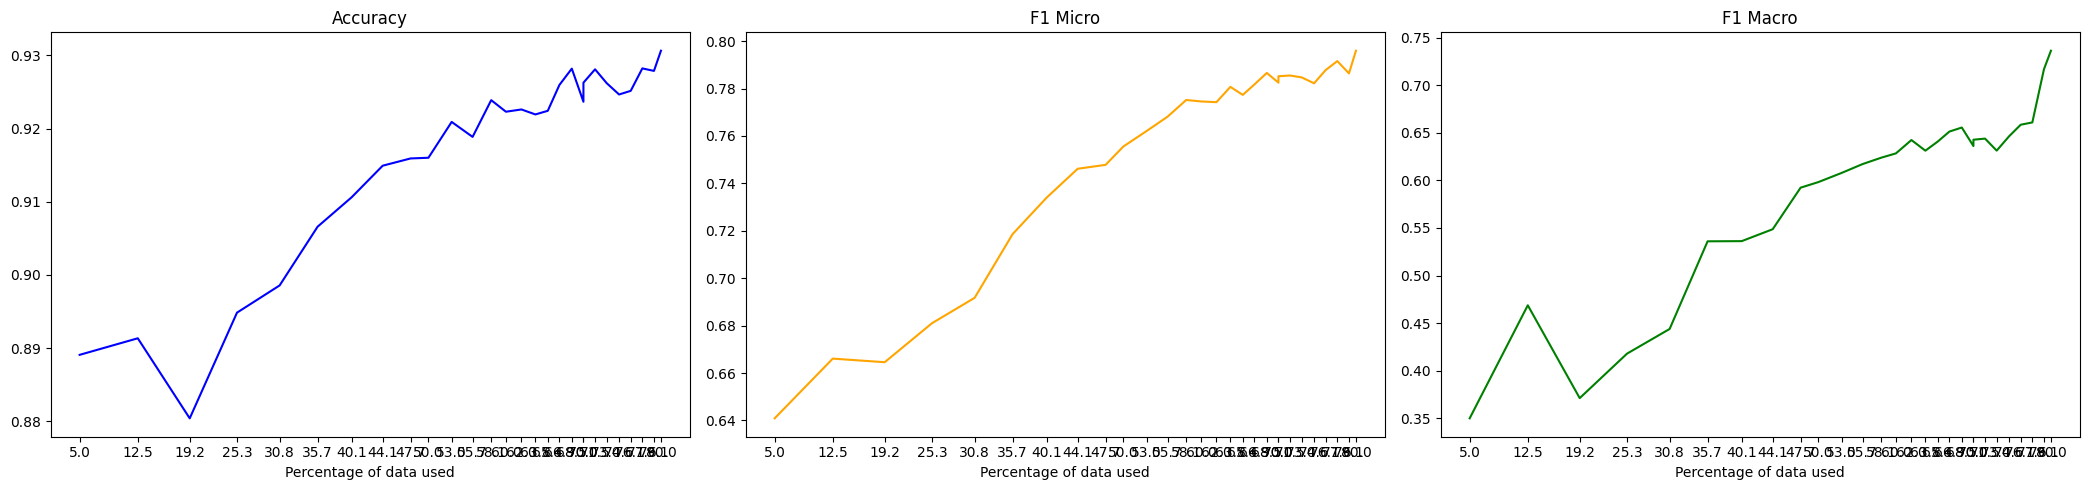

In [24]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.8293, F1 Micro: 0.063, F1 Macro: 0.0218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.8417, F1 Micro: 0.2125, F1 Macro: 0.0699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.389, Accuracy: 0.8438, F1 Micro: 0.2285, F1 Macro: 0.0804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8604, F1 Micro: 0.4052, F1 Macro: 0.1597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8723, F1 Micro: 0.5143, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2817, Accuracy: 0.8774, F1 Micro: 0.5561, F1 Macro: 0.2819
Epoch 7/10, Train Loss: 0.2562, Accuracy: 0.8755, F1 Micro: 0.5114, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2286, Accuracy: 0.884, F1 Micro: 0.5828, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.204, Accuracy: 0.8891, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.8464, F1 Micro: 0.3189, F1 Macro: 0.1144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.8677, F1 Micro: 0.55, F1 Macro: 0.255
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.8755, F1 Micro: 0.5477, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.8794, F1 Micro: 0.5672, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.8836, F1 Micro: 0.6339, F1 Macro: 0.356
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.8886, F1 Micro: 0.6333, F1 Macro: 0.3559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.8914, F1 Micro: 0.6664, F1 Macro: 0.3942
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.8917, F1 Micro: 0.6483, F1 Macro: 0.398
Higher F1 achieved, saving model
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3057, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1948, Accuracy: 0.8622, F1 Micro: 0.4498, F1 Macro: 0.1864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1451, Accuracy: 0.8725, F1 Micro: 0.5292, F1 Macro: 0.2459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.8724, F1 Micro: 0.6501, F1 Macro: 0.3609
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.8795, F1 Micro: 0.6325, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.885, F1 Micro: 0.6702, F1 Macro: 0.3886
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.8907, F1 Micro: 0.6371, F1 Macro: 0.3965
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.8925, F1 Micro: 0.683, F1 Macro: 0.4339
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.8963, F1 Micro: 0.6787, F1 Macro: 0.4343
Epoch 10/10, Train Loss: 0.0484, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2776, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.8658, F1 Micro: 0.5266, F1 Macro: 0.2418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1282, Accuracy: 0.8733, F1 Micro: 0.5466, F1 Macro: 0.2626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1128, Accuracy: 0.8786, F1 Micro: 0.5951, F1 Macro: 0.3084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0972, Accuracy: 0.8838, F1 Micro: 0.6074, F1 Macro: 0.3097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.8959, F1 Micro: 0.6682, F1 Macro: 0.3904
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.888, F1 Micro: 0.6865, F1 Macro: 0.4355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.8995, F1 Micro: 0.6895, F1 Macro: 0.4306
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8939, F1 Micro: 0.679

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2621, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1733, Accuracy: 0.8708, F1 Micro: 0.5663, F1 Macro: 0.2708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1376, Accuracy: 0.881, F1 Micro: 0.6237, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1134, Accuracy: 0.889, F1 Micro: 0.647, F1 Macro: 0.3847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0867, Accuracy: 0.8975, F1 Micro: 0.6817, F1 Macro: 0.4588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0737, Accuracy: 0.8965, F1 Micro: 0.6947, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.898, F1 Micro: 0.71, F1 Macro: 0.4883
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8985, F1 Micro: 0.704, F1 Macro: 0.4453
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.8982, F1 Micro: 0.7135, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2571, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.8621, F1 Micro: 0.4083, F1 Macro: 0.1898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1399, Accuracy: 0.8869, F1 Micro: 0.6033, F1 Macro: 0.3202
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1128, Accuracy: 0.8935, F1 Micro: 0.6482, F1 Macro: 0.3874
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0857, Accuracy: 0.8974, F1 Micro: 0.7067, F1 Macro: 0.483
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9003, F1 Micro: 0.6924, F1 Macro: 0.4412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9045, F1 Micro: 0.7133, F1 Macro: 0.4818
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.904, F1 Micro: 0.7138, F1 Macro: 0.5068
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.8991, F1 Micro: 0.6918, F1 Macro: 0.4812
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.262, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1893, Accuracy: 0.8711, F1 Micro: 0.4798, F1 Macro: 0.2266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1413, Accuracy: 0.8896, F1 Micro: 0.6467, F1 Macro: 0.3825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.9026, F1 Micro: 0.7041, F1 Macro: 0.4624
Epoch 5/10, Train Loss: 0.0876, Accuracy: 0.905, F1 Micro: 0.6941, F1 Macro: 0.4414
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0732, Accuracy: 0.9072, F1 Micro: 0.7217, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.9086, F1 Micro: 0.7242, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9075, F1 Micro: 0.7294, F1 Macro: 0.4981
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9058, F1 Micro: 0.73

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2811, Accuracy: 0.8326, F1 Micro: 0.0706, F1 Macro: 0.0276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.8901, F1 Micro: 0.6483, F1 Macro: 0.3385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9015, F1 Micro: 0.6917, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1177, Accuracy: 0.9095, F1 Micro: 0.7257, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0889, Accuracy: 0.9091, F1 Micro: 0.7369, F1 Macro: 0.5511
Epoch 6/10, Train Loss: 0.0737, Accuracy: 0.9088, F1 Micro: 0.7367, F1 Macro: 0.538
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9107, F1 Micro: 0.7269, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9151, F1 Micro: 0.7439, F1 Macro: 0.5737
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.907, F1 Micro: 0.7437, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2877, Accuracy: 0.8627, F1 Micro: 0.4479, F1 Macro: 0.2304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.896, F1 Micro: 0.6316, F1 Macro: 0.3847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9064, F1 Micro: 0.7284, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1175, Accuracy: 0.9064, F1 Micro: 0.7357, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0938, Accuracy: 0.9169, F1 Micro: 0.745, F1 Macro: 0.5888
Epoch 6/10, Train Loss: 0.0788, Accuracy: 0.915, F1 Micro: 0.7418, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9098, F1 Micro: 0.7496, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9191, F1 Micro: 0.7583, F1 Macro: 0.6002
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9148, F1 Micro: 0.7458, F1 Macro: 0.5919
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2969, Accuracy: 0.8516, F1 Micro: 0.2775, F1 Macro: 0.1226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9025, F1 Micro: 0.6973, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9062, F1 Micro: 0.7404, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1178, Accuracy: 0.9163, F1 Micro: 0.7448, F1 Macro: 0.5779
Epoch 5/10, Train Loss: 0.0949, Accuracy: 0.9106, F1 Micro: 0.742, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9212, F1 Micro: 0.7511, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.917, F1 Micro: 0.7548, F1 Macro: 0.597
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9148, F1 Micro: 0.7537, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9182, F1 Micro: 0.7587, F1 Macro: 0.5956
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3018, Accuracy: 0.878, F1 Micro: 0.5398, F1 Macro: 0.3031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.9068, F1 Micro: 0.684, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9108, F1 Micro: 0.6935, F1 Macro: 0.5509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1239, Accuracy: 0.9174, F1 Micro: 0.7584, F1 Macro: 0.594
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9175, F1 Micro: 0.7501, F1 Macro: 0.5977
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9164, F1 Micro: 0.7406, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9209, F1 Micro: 0.7595, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9192, F1 Micro: 0.7598, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9202, F1 Micro: 0.7604, F1 Macro: 0.6133
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3142, Accuracy: 0.8753, F1 Micro: 0.4764, F1 Macro: 0.2519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1999, Accuracy: 0.9067, F1 Micro: 0.6999, F1 Macro: 0.5351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9118, F1 Micro: 0.7521, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9213, F1 Micro: 0.767, F1 Macro: 0.6115
Epoch 5/10, Train Loss: 0.1005, Accuracy: 0.919, F1 Micro: 0.7558, F1 Macro: 0.6102
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.921, F1 Micro: 0.7608, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9155, F1 Micro: 0.7673, F1 Macro: 0.6136
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9202, F1 Micro: 0.7587, F1 Macro: 0.6123
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9171, F1 Micro: 0.7606, F1 Macro: 0.6163
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9166, F1 Micro: 0.7664, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3115, Accuracy: 0.8916, F1 Micro: 0.6499, F1 Macro: 0.4283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9145, F1 Micro: 0.7366, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9187, F1 Micro: 0.7622, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9201, F1 Micro: 0.7727, F1 Macro: 0.6196
Epoch 5/10, Train Loss: 0.0996, Accuracy: 0.9201, F1 Micro: 0.7586, F1 Macro: 0.6165
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9218, F1 Micro: 0.7695, F1 Macro: 0.6188
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9209, F1 Micro: 0.766, F1 Macro: 0.6162
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9205, F1 Micro: 0.7708, F1 Macro: 0.6232
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9243, F1 Micro: 0.7712, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9241, F1 Micro: 0.774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3193, Accuracy: 0.8822, F1 Micro: 0.5327, F1 Macro: 0.3147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2094, Accuracy: 0.9135, F1 Micro: 0.7187, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9188, F1 Micro: 0.7528, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9212, F1 Micro: 0.7659, F1 Macro: 0.612
Epoch 5/10, Train Loss: 0.1026, Accuracy: 0.9192, F1 Micro: 0.7608, F1 Macro: 0.6166
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9187, F1 Micro: 0.7595, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.9173, F1 Micro: 0.7677, F1 Macro: 0.6132
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9212, F1 Micro: 0.7675, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9233, F1 Micro: 0.7796, F1 Macro: 0.657
Epoch 10/10, Train Loss: 0.042, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.317, Accuracy: 0.8956, F1 Micro: 0.6665, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.206, Accuracy: 0.9133, F1 Micro: 0.7416, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9164, F1 Micro: 0.7432, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1292, Accuracy: 0.9226, F1 Micro: 0.7705, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.9225, F1 Micro: 0.7728, F1 Macro: 0.613
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9236, F1 Micro: 0.7658, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9223, F1 Micro: 0.7754, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9263, F1 Micro: 0.7824, F1 Macro: 0.6272
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9165, F1 Micro: 0.7711, F1 Macro: 0.6425
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3163, Accuracy: 0.8982, F1 Micro: 0.6989, F1 Macro: 0.5225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2047, Accuracy: 0.9169, F1 Micro: 0.744, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9197, F1 Micro: 0.7693, F1 Macro: 0.6126
Epoch 4/10, Train Loss: 0.1259, Accuracy: 0.9225, F1 Micro: 0.7649, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9191, F1 Micro: 0.7694, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9212, F1 Micro: 0.7751, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9227, F1 Micro: 0.7755, F1 Macro: 0.6297
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9223, F1 Micro: 0.7703, F1 Macro: 0.6343
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9258, F1 Micro: 0.7802, F1 Macro: 0.6366
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3193, Accuracy: 0.8825, F1 Micro: 0.5245, F1 Macro: 0.292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2102, Accuracy: 0.9174, F1 Micro: 0.7483, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1654, Accuracy: 0.9222, F1 Micro: 0.7498, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9202, F1 Micro: 0.7687, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1023, Accuracy: 0.926, F1 Micro: 0.7728, F1 Macro: 0.6187
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9218, F1 Micro: 0.7628, F1 Macro: 0.6185
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9216, F1 Micro: 0.765, F1 Macro: 0.6201
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9222, F1 Micro: 0.7682, F1 Macro: 0.6386
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9208, F1 Micro: 0.7723, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0418, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3161, Accuracy: 0.9003, F1 Micro: 0.6587, F1 Macro: 0.4461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2087, Accuracy: 0.9152, F1 Micro: 0.7156, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9236, F1 Micro: 0.7581, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9154, F1 Micro: 0.7677, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9258, F1 Micro: 0.7724, F1 Macro: 0.6273
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9222, F1 Micro: 0.7756, F1 Macro: 0.6352
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9247, F1 Micro: 0.7701, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9252, F1 Micro: 0.7769, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9254, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3188, Accuracy: 0.9023, F1 Micro: 0.6872, F1 Macro: 0.4922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.9192, F1 Micro: 0.7401, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9249, F1 Micro: 0.774, F1 Macro: 0.6045
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9255, F1 Micro: 0.7728, F1 Macro: 0.6134
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9239, F1 Micro: 0.7676, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9262, F1 Micro: 0.7808, F1 Macro: 0.628
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9253, F1 Micro: 0.7718, F1 Macro: 0.6318
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9246, F1 Micro: 0.7716, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9236, F1 Micro: 0.7821, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0419, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3156, Accuracy: 0.9039, F1 Micro: 0.6867, F1 Macro: 0.4437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2092, Accuracy: 0.9182, F1 Micro: 0.7485, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9232, F1 Micro: 0.77, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9258, F1 Micro: 0.7774, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0996, Accuracy: 0.9273, F1 Micro: 0.7821, F1 Macro: 0.6291
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9254, F1 Micro: 0.7755, F1 Macro: 0.6289
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9237, F1 Micro: 0.7714, F1 Macro: 0.6428
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9247, F1 Micro: 0.7803, F1 Macro: 0.6508
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9271, F1 Micro: 0.779, F1 Macro: 0.6469
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.924, F1 Micro: 0.7749, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3237, Accuracy: 0.9036, F1 Micro: 0.708, F1 Macro: 0.5039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.917, F1 Micro: 0.7467, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9248, F1 Micro: 0.7717, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9274, F1 Micro: 0.7805, F1 Macro: 0.6311
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9225, F1 Micro: 0.7749, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0814, Accuracy: 0.9253, F1 Micro: 0.781, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.9264, F1 Micro: 0.7814, F1 Macro: 0.6438
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.926, F1 Micro: 0.7752, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9233, F1 Micro: 0.7703, F1 Macro: 0.6441
Epoch 10/10, Train Loss: 0.0401, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9048, F1 Micro: 0.7111, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2089, Accuracy: 0.9185, F1 Micro: 0.7473, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9243, F1 Micro: 0.7672, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9218, F1 Micro: 0.7767, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.928, F1 Micro: 0.7862, F1 Macro: 0.6386
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9256, F1 Micro: 0.7805, F1 Macro: 0.6379
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9271, F1 Micro: 0.7797, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9275, F1 Micro: 0.7802, F1 Macro: 0.6431
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.926, F1 Micro: 0.7779, F1 Macro: 0.6531
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9271, F1 Micro: 0.7802, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3135, Accuracy: 0.9055, F1 Micro: 0.7236, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9196, F1 Micro: 0.75, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9257, F1 Micro: 0.7802, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.928, F1 Micro: 0.7859, F1 Macro: 0.6341
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9247, F1 Micro: 0.78, F1 Macro: 0.6333
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.9226, F1 Micro: 0.7799, F1 Macro: 0.6421
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9257, F1 Micro: 0.7789, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9274, F1 Micro: 0.7847, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9282, F1 Micro: 0.7867, F1 Macro: 0.657
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.922, F1 Micro: 0.7804, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9038, F1 Micro: 0.6754, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.21, Accuracy: 0.9196, F1 Micro: 0.7606, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9203, F1 Micro: 0.7757, F1 Macro: 0.6156
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9199, F1 Micro: 0.7451, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9264, F1 Micro: 0.7892, F1 Macro: 0.6471
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9212, F1 Micro: 0.7799, F1 Macro: 0.643
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9293, F1 Micro: 0.7887, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9277, F1 Micro: 0.7822, F1 Macro: 0.6554
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.926, F1 Micro: 0.7829, F1 Macro: 0.6632
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9277, F1 Micro: 0.7876, F1 Macro: 0.6785
Iteration 9818: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3221, Accuracy: 0.9067, F1 Micro: 0.7192, F1 Macro: 0.5018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2111, Accuracy: 0.9216, F1 Micro: 0.7638, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9251, F1 Micro: 0.7712, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9268, F1 Micro: 0.7766, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9264, F1 Micro: 0.7914, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9276, F1 Micro: 0.7896, F1 Macro: 0.6614
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9294, F1 Micro: 0.7889, F1 Macro: 0.6781
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9287, F1 Micro: 0.7859, F1 Macro: 0.69
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9263, F1 Micro: 0.788, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0395, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3191, Accuracy: 0.902, F1 Micro: 0.6593, F1 Macro: 0.4512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9209, F1 Micro: 0.7628, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9242, F1 Micro: 0.7718, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9254, F1 Micro: 0.7804, F1 Macro: 0.6405
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9272, F1 Micro: 0.7767, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9289, F1 Micro: 0.7876, F1 Macro: 0.6733
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9255, F1 Micro: 0.7862, F1 Macro: 0.6638
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9254, F1 Micro: 0.7859, F1 Macro: 0.693
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9262, F1 Micro: 0.7836, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.043, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3202, Accuracy: 0.9067, F1 Micro: 0.7153, F1 Macro: 0.5077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9202, F1 Micro: 0.758, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9217, F1 Micro: 0.7816, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9238, F1 Micro: 0.7847, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9281, F1 Micro: 0.7869, F1 Macro: 0.6867
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.927, F1 Micro: 0.7843, F1 Macro: 0.6859
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9269, F1 Micro: 0.7866, F1 Macro: 0.7048
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9274, F1 Micro: 0.7782, F1 Macro: 0.6968
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9263, F1 Micro: 0.7866, F1 Macro: 0.7139
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.927, F1 Micro: 0.7806, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3243, Accuracy: 0.9071, F1 Micro: 0.707, F1 Macro: 0.51
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9208, F1 Micro: 0.7687, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9219, F1 Micro: 0.7766, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9284, F1 Micro: 0.7926, F1 Macro: 0.6856
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9288, F1 Micro: 0.7916, F1 Macro: 0.6953
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9295, F1 Micro: 0.7924, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9289, F1 Micro: 0.7943, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9251, F1 Micro: 0.7898, F1 Macro: 0.7258
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9294, F1 Micro: 0.7941, F1 Macro: 0.7266
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9297, F1 Micro: 0.7904, F1 Ma

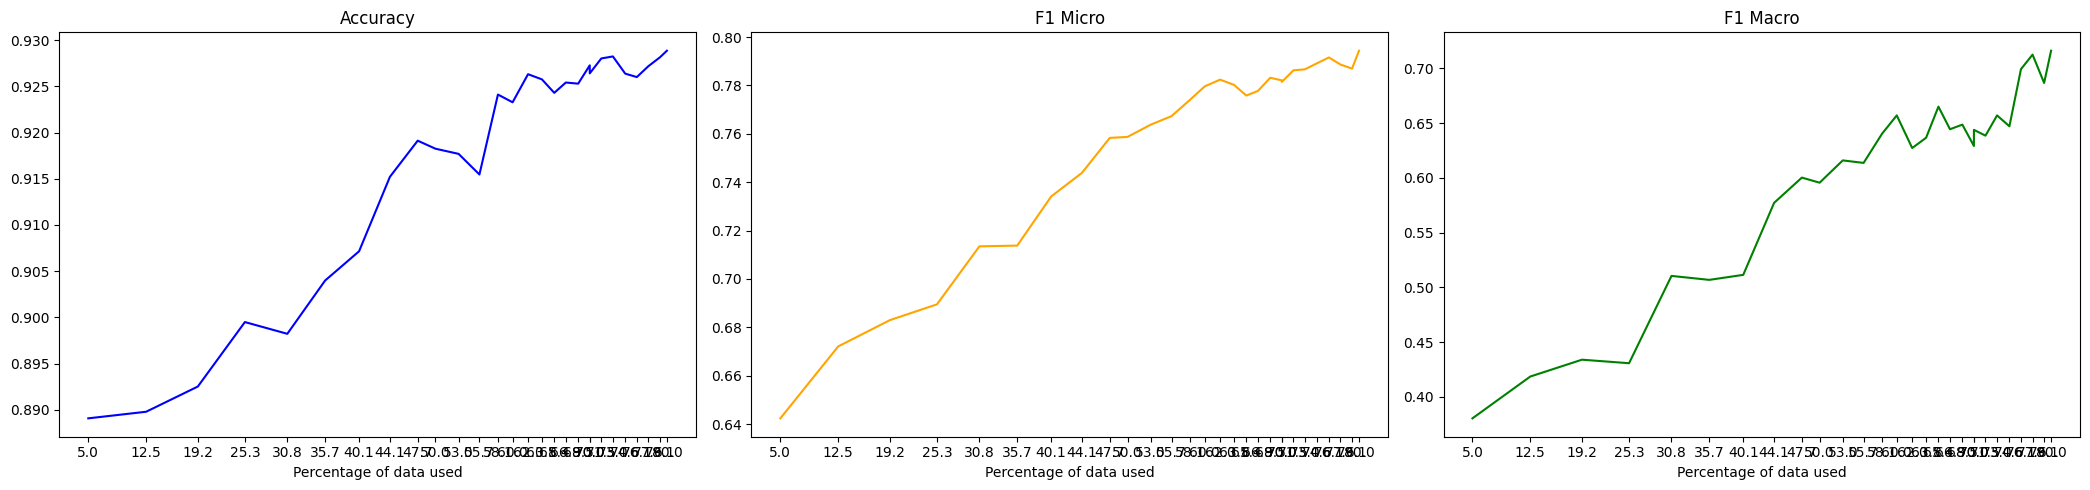

In [25]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8279, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.8342, F1 Micro: 0.1125, F1 Macro: 0.0406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.372, Accuracy: 0.844, F1 Micro: 0.2472, F1 Macro: 0.0837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.8621, F1 Micro: 0.468, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3382, Accuracy: 0.8729, F1 Micro: 0.5892, F1 Macro: 0.2711
Epoch 6/10, Train Loss: 0.2935, Accuracy: 0.8774, F1 Micro: 0.5687, F1 Macro: 0.2658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2645, Accuracy: 0.8822, F1 Micro: 0.6084, F1 Macro: 0.293
Epoch 8/10, Train Loss: 0.2436, Accuracy: 0.8842, F1 Micro: 0.6042, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2213, Accuracy: 0.8868, F1 Micro: 0.6313, F1 Macro: 0.3455
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.8449, F1 Micro: 0.2807, F1 Macro: 0.1052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.8615, F1 Micro: 0.4218, F1 Macro: 0.194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.8696, F1 Micro: 0.5504, F1 Macro: 0.2578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.8713, F1 Micro: 0.6184, F1 Macro: 0.2881
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.8802, F1 Micro: 0.5905, F1 Macro: 0.2787
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.8836, F1 Micro: 0.6472, F1 Macro: 0.3537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.8852, F1 Micro: 0.6476, F1 Macro: 0.3523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.8891, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3184, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.8558, F1 Micro: 0.49, F1 Macro: 0.2219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.8678, F1 Micro: 0.5711, F1 Macro: 0.2642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.8766, F1 Micro: 0.5821, F1 Macro: 0.2728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.8768, F1 Micro: 0.5873, F1 Macro: 0.2751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.8789, F1 Micro: 0.6447, F1 Macro: 0.3414
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.8848, F1 Micro: 0.6447, F1 Macro: 0.3552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.8939, F1 Micro: 0.6679, F1 Macro: 0.4218
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.8927, F1 Micro: 0.6679, F1 Macro: 0.4106
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2868, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.8579, F1 Micro: 0.3747, F1 Macro: 0.1695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1428, Accuracy: 0.8752, F1 Micro: 0.5288, F1 Macro: 0.248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.8802, F1 Micro: 0.6306, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0984, Accuracy: 0.8809, F1 Micro: 0.657, F1 Macro: 0.3702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.889, F1 Micro: 0.6662, F1 Macro: 0.3809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8902, F1 Micro: 0.6791, F1 Macro: 0.4259
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.8969, F1 Micro: 0.688, F1 Macro: 0.4441
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0504, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2698, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1767, Accuracy: 0.8655, F1 Micro: 0.5545, F1 Macro: 0.2586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.871, F1 Micro: 0.6351, F1 Macro: 0.2939
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.8854, F1 Micro: 0.6024, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0968, Accuracy: 0.8915, F1 Micro: 0.6646, F1 Macro: 0.3556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.8863, F1 Micro: 0.6763, F1 Macro: 0.3962
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0624, Accuracy: 0.8961, F1 Micro: 0.6864, F1 Macro: 0.4386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9001, F1 Micro: 0.6895, F1 Macro: 0.429
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.8892, F1 Micro: 0.691

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2665, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.8523, F1 Micro: 0.3041, F1 Macro: 0.1402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.8796, F1 Micro: 0.6346, F1 Macro: 0.2965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1187, Accuracy: 0.8901, F1 Micro: 0.6519, F1 Macro: 0.3416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0884, Accuracy: 0.8925, F1 Micro: 0.6647, F1 Macro: 0.3783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.8984, F1 Micro: 0.6924, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9021, F1 Micro: 0.7012, F1 Macro: 0.482
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8945, F1 Micro: 0.7032, F1 Macro: 0.4914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0451,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2733, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1951, Accuracy: 0.8778, F1 Micro: 0.5626, F1 Macro: 0.2684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1473, Accuracy: 0.8869, F1 Micro: 0.6672, F1 Macro: 0.3503
Epoch 4/10, Train Loss: 0.1211, Accuracy: 0.8943, F1 Micro: 0.6322, F1 Macro: 0.3905
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0961, Accuracy: 0.8965, F1 Micro: 0.6967, F1 Macro: 0.4662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.9001, F1 Micro: 0.7055, F1 Macro: 0.4757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9009, F1 Micro: 0.7111, F1 Macro: 0.4638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9029, F1 Micro: 0.7198, F1 Macro: 0.4868
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9057, F1 Micro: 0.717, F1 Macro: 0.507
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2907, Accuracy: 0.8332, F1 Micro: 0.0816, F1 Macro: 0.0312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1991, Accuracy: 0.8886, F1 Micro: 0.6368, F1 Macro: 0.3187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.8979, F1 Micro: 0.6901, F1 Macro: 0.3741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1228, Accuracy: 0.9046, F1 Micro: 0.7071, F1 Macro: 0.4655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0972, Accuracy: 0.9038, F1 Micro: 0.7162, F1 Macro: 0.4559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.9115, F1 Micro: 0.7252, F1 Macro: 0.519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9136, F1 Micro: 0.7417, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9116, F1 Micro: 0.7438, F1 Macro: 0.5647
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.91, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2982, Accuracy: 0.8542, F1 Micro: 0.3072, F1 Macro: 0.1219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2005, Accuracy: 0.8973, F1 Micro: 0.6544, F1 Macro: 0.4491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1587, Accuracy: 0.9047, F1 Micro: 0.6879, F1 Macro: 0.4776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.123, Accuracy: 0.9109, F1 Micro: 0.7223, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9014, F1 Micro: 0.7316, F1 Macro: 0.5595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9165, F1 Micro: 0.7592, F1 Macro: 0.6047
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9181, F1 Micro: 0.7538, F1 Macro: 0.5872
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9183, F1 Micro: 0.7544, F1 Macro: 0.5958
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9147, F1 Micro: 0.7509, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3097, Accuracy: 0.8618, F1 Micro: 0.4074, F1 Macro: 0.2029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2078, Accuracy: 0.8944, F1 Micro: 0.6176, F1 Macro: 0.3679
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1569, Accuracy: 0.9115, F1 Micro: 0.7284, F1 Macro: 0.5473
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1227, Accuracy: 0.913, F1 Micro: 0.7323, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9169, F1 Micro: 0.7484, F1 Macro: 0.5909
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9119, F1 Micro: 0.7479, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9171, F1 Micro: 0.7539, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9183, F1 Micro: 0.759, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.918, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.31, Accuracy: 0.8616, F1 Micro: 0.3866, F1 Macro: 0.198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9062, F1 Micro: 0.7188, F1 Macro: 0.5322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9077, F1 Micro: 0.7417, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1231, Accuracy: 0.9194, F1 Micro: 0.7592, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0967, Accuracy: 0.918, F1 Micro: 0.7629, F1 Macro: 0.6
Epoch 6/10, Train Loss: 0.0783, Accuracy: 0.9201, F1 Micro: 0.7606, F1 Macro: 0.6107
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.909, F1 Micro: 0.7428, F1 Macro: 0.5987
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9195, F1 Micro: 0.76, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9206, F1 Micro: 0.7672, F1 Macro: 0.6129
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.920

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3203, Accuracy: 0.8731, F1 Micro: 0.4613, F1 Macro: 0.2346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2098, Accuracy: 0.9093, F1 Micro: 0.7, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9124, F1 Micro: 0.7549, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.919, F1 Micro: 0.7567, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.9171, F1 Micro: 0.761, F1 Macro: 0.6028
Epoch 6/10, Train Loss: 0.0742, Accuracy: 0.9163, F1 Micro: 0.752, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9186, F1 Micro: 0.7629, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9227, F1 Micro: 0.7632, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9198, F1 Micro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.8894, F1 Micro: 0.5914, F1 Macro: 0.3431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9101, F1 Micro: 0.7462, F1 Macro: 0.589
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9161, F1 Micro: 0.7413, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9192, F1 Micro: 0.7659, F1 Macro: 0.6081
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.9209, F1 Micro: 0.7658, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.9205, F1 Micro: 0.7751, F1 Macro: 0.6205
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9231, F1 Micro: 0.774, F1 Macro: 0.6253
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9238, F1 Micro: 0.7751, F1 Macro: 0.6272
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9236, F1 Micro: 0.7695, F1 Macro: 0.6214
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9207, F1 Micro: 0.7714, F1 Macro: 0.6427
Iteration 7656: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.323, Accuracy: 0.8926, F1 Micro: 0.6232, F1 Macro: 0.3884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2138, Accuracy: 0.9104, F1 Micro: 0.6988, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9189, F1 Micro: 0.7619, F1 Macro: 0.6037
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9221, F1 Micro: 0.7606, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0988, Accuracy: 0.9219, F1 Micro: 0.7721, F1 Macro: 0.6212
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9146, F1 Micro: 0.7669, F1 Macro: 0.6185
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9241, F1 Micro: 0.7721, F1 Macro: 0.6231
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9192, F1 Micro: 0.7674, F1 Macro: 0.6158
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9204, F1 Micro: 0.761, F1 Macro: 0.6138
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9207, F1 Micro: 0.7665, F1 Macro: 0.6253
Iteration 7901: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.8921, F1 Micro: 0.5962, F1 Macro: 0.3397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9107, F1 Micro: 0.7082, F1 Macro: 0.4931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1587, Accuracy: 0.9207, F1 Micro: 0.7553, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1332, Accuracy: 0.9202, F1 Micro: 0.7685, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0985, Accuracy: 0.9254, F1 Micro: 0.7791, F1 Macro: 0.6232
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.921, F1 Micro: 0.762, F1 Macro: 0.6005
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9265, F1 Micro: 0.7741, F1 Macro: 0.6326
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9225, F1 Micro: 0.7742, F1 Macro: 0.6536
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9227, F1 Micro: 0.7726, F1 Macro: 0.6392
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9258, F1 Micro: 0.7669, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3275, Accuracy: 0.9003, F1 Micro: 0.6897, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9121, F1 Micro: 0.7247, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9108, F1 Micro: 0.757, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1269, Accuracy: 0.9246, F1 Micro: 0.7784, F1 Macro: 0.6263
Epoch 5/10, Train Loss: 0.1006, Accuracy: 0.9229, F1 Micro: 0.7702, F1 Macro: 0.6234
Epoch 6/10, Train Loss: 0.0808, Accuracy: 0.9242, F1 Micro: 0.7725, F1 Macro: 0.6232
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9232, F1 Micro: 0.7722, F1 Macro: 0.62
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9196, F1 Micro: 0.7725, F1 Macro: 0.6242
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9222, F1 Micro: 0.7731, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9266, F1 Micro: 0.7826, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.8966, F1 Micro: 0.6343, F1 Macro: 0.3792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2071, Accuracy: 0.9125, F1 Micro: 0.7224, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9219, F1 Micro: 0.7564, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9227, F1 Micro: 0.7637, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1026, Accuracy: 0.9206, F1 Micro: 0.7754, F1 Macro: 0.6252
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.9218, F1 Micro: 0.7649, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9237, F1 Micro: 0.7775, F1 Macro: 0.6285
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9203, F1 Micro: 0.7718, F1 Macro: 0.6357
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9235, F1 Micro: 0.7702, F1 Macro: 0.6439
Epoch 10/10, Train Loss: 0.0414, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3214, Accuracy: 0.8973, F1 Micro: 0.6294, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2135, Accuracy: 0.9148, F1 Micro: 0.7324, F1 Macro: 0.538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.924, F1 Micro: 0.766, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9246, F1 Micro: 0.7749, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1032, Accuracy: 0.9254, F1 Micro: 0.7838, F1 Macro: 0.6359
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9203, F1 Micro: 0.7635, F1 Macro: 0.6179
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9183, F1 Micro: 0.7679, F1 Macro: 0.6213
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9241, F1 Micro: 0.7817, F1 Macro: 0.6359
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9247, F1 Micro: 0.7801, F1 Macro: 0.6438
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9265, F1 Micro: 0.776, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.8932, F1 Micro: 0.6048, F1 Macro: 0.4089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9169, F1 Micro: 0.7462, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9228, F1 Micro: 0.7623, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9232, F1 Micro: 0.7714, F1 Macro: 0.6151
Epoch 5/10, Train Loss: 0.1014, Accuracy: 0.9231, F1 Micro: 0.7692, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9239, F1 Micro: 0.779, F1 Macro: 0.6426
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.923, F1 Micro: 0.7677, F1 Macro: 0.6361
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9252, F1 Micro: 0.7692, F1 Macro: 0.6491
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9231, F1 Micro: 0.777, F1 Macro: 0.6697
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9249, F1 Micro: 0.7755, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3244, Accuracy: 0.9027, F1 Micro: 0.6904, F1 Macro: 0.4337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9181, F1 Micro: 0.7368, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9235, F1 Micro: 0.7666, F1 Macro: 0.6027
Epoch 4/10, Train Loss: 0.1332, Accuracy: 0.9253, F1 Micro: 0.764, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1042, Accuracy: 0.9258, F1 Micro: 0.7814, F1 Macro: 0.6326
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9215, F1 Micro: 0.779, F1 Macro: 0.6586
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9229, F1 Micro: 0.7794, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9233, F1 Micro: 0.7766, F1 Macro: 0.6538
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9194, F1 Micro: 0.7706, F1 Macro: 0.6399
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9261, F1 Micro: 0.7793, F1 Macro: 0.6626
Iteration 9216: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3275, Accuracy: 0.9035, F1 Micro: 0.7004, F1 Macro: 0.4979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.9157, F1 Micro: 0.7479, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.924, F1 Micro: 0.7666, F1 Macro: 0.6135
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9166, F1 Micro: 0.7625, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9229, F1 Micro: 0.7678, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9237, F1 Micro: 0.7759, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9235, F1 Micro: 0.7799, F1 Macro: 0.6605
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9217, F1 Micro: 0.7765, F1 Macro: 0.6617
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9214, F1 Micro: 0.7796, F1 Macro: 0.6734
Epoch 10/10, Train Loss: 0.0442, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3292, Accuracy: 0.9002, F1 Micro: 0.7127, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2118, Accuracy: 0.919, F1 Micro: 0.7477, F1 Macro: 0.5823
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9231, F1 Micro: 0.7474, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9259, F1 Micro: 0.7715, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9218, F1 Micro: 0.7732, F1 Macro: 0.6274
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9161, F1 Micro: 0.7661, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9231, F1 Micro: 0.7735, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9212, F1 Micro: 0.7719, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9259, F1 Micro: 0.7766, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3278, Accuracy: 0.9066, F1 Micro: 0.7079, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2145, Accuracy: 0.9141, F1 Micro: 0.757, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9246, F1 Micro: 0.7784, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.927, F1 Micro: 0.7838, F1 Macro: 0.6299
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9265, F1 Micro: 0.782, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9266, F1 Micro: 0.787, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.924, F1 Micro: 0.7787, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9241, F1 Micro: 0.7793, F1 Macro: 0.6866
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9229, F1 Micro: 0.7783, F1 Macro: 0.679
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9279, F1 Micro: 0.7845, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.906, F1 Micro: 0.7088, F1 Macro: 0.4941
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.9182, F1 Micro: 0.7618, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9272, F1 Micro: 0.7783, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9269, F1 Micro: 0.7809, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.928, F1 Micro: 0.7832, F1 Macro: 0.6425
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9272, F1 Micro: 0.7805, F1 Macro: 0.6566
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9271, F1 Micro: 0.782, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9289, F1 Micro: 0.7889, F1 Macro: 0.7038
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9282, F1 Micro: 0.7881, F1 Macro: 0.6988
Epoch 10/10, Train Loss: 0.0438, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9062, F1 Micro: 0.722, F1 Macro: 0.5009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9185, F1 Micro: 0.7526, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9246, F1 Micro: 0.7751, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.922, F1 Micro: 0.7786, F1 Macro: 0.6418
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.924, F1 Micro: 0.778, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9281, F1 Micro: 0.7847, F1 Macro: 0.6787
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9274, F1 Micro: 0.7797, F1 Macro: 0.6732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9277, F1 Micro: 0.785, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9281, F1 Micro: 0.7811, F1 Macro: 0.6865
Epoch 10/10, Train Loss: 0.0388, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.9061, F1 Micro: 0.6898, F1 Macro: 0.4535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2138, Accuracy: 0.9201, F1 Micro: 0.7585, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9261, F1 Micro: 0.7767, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9277, F1 Micro: 0.7783, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9223, F1 Micro: 0.7829, F1 Macro: 0.6737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9301, F1 Micro: 0.7889, F1 Macro: 0.6947
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9273, F1 Micro: 0.7853, F1 Macro: 0.7065
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9248, F1 Micro: 0.7829, F1 Macro: 0.7148
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9257, F1 Micro: 0.7834, F1 Macro: 0.7199
Epoch 10/10, Train Loss: 0.0427, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3274, Accuracy: 0.9037, F1 Micro: 0.7043, F1 Macro: 0.4569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.918, F1 Micro: 0.738, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9246, F1 Micro: 0.7825, F1 Macro: 0.6535
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.928, F1 Micro: 0.7796, F1 Macro: 0.6644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9276, F1 Micro: 0.7829, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.928, F1 Micro: 0.7837, F1 Macro: 0.7085
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9289, F1 Micro: 0.7848, F1 Macro: 0.7252
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.922, F1 Micro: 0.7752, F1 Macro: 0.7088
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9272, F1 Micro: 0.7836, F1 Macro: 0.7148
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3269, Accuracy: 0.9083, F1 Micro: 0.7306, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.9207, F1 Micro: 0.7629, F1 Macro: 0.5855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9264, F1 Micro: 0.7806, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9243, F1 Micro: 0.7836, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9289, F1 Micro: 0.7918, F1 Macro: 0.7112
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.927, F1 Micro: 0.7759, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9311, F1 Micro: 0.7964, F1 Macro: 0.7271
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9277, F1 Micro: 0.7902, F1 Macro: 0.7269
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9305, F1 Micro: 0.7924, F1 Macro: 0.7238
Epoch 10/10, Train Loss: 0.0423, Accur

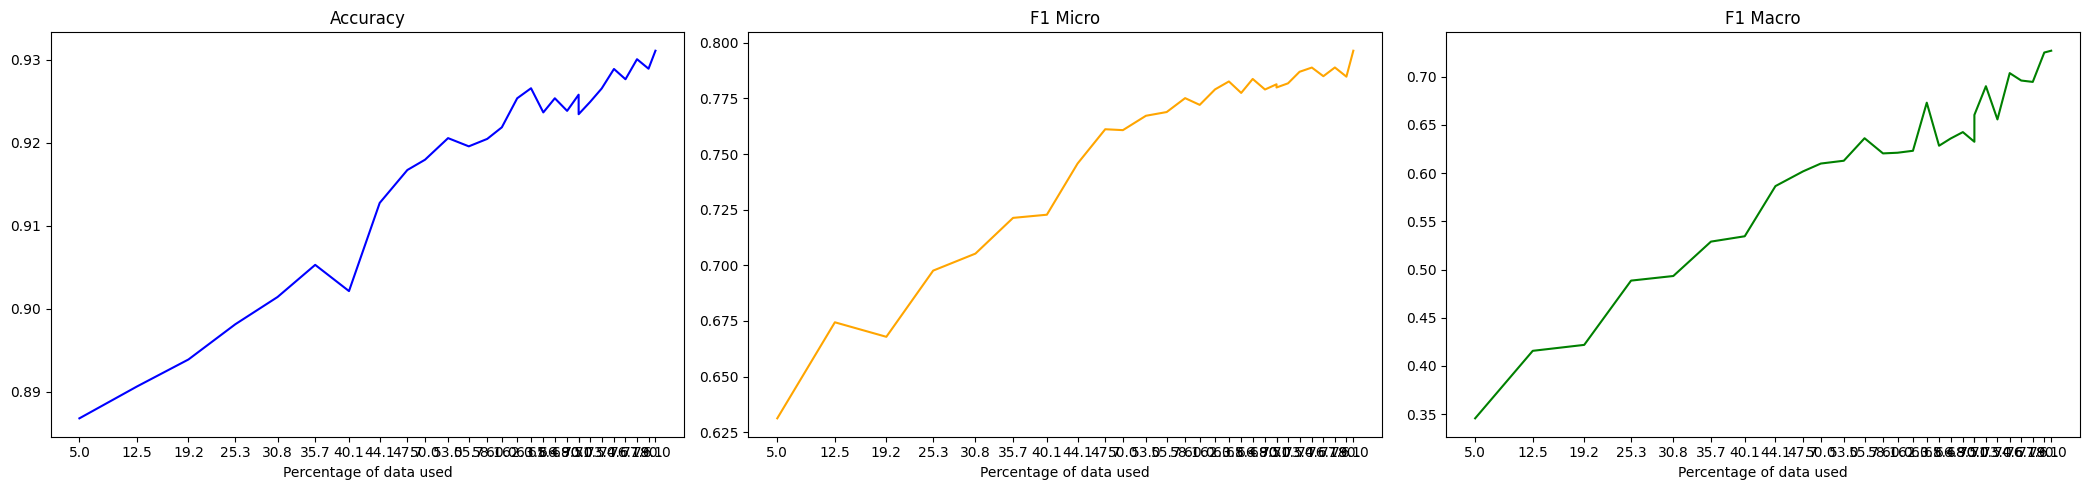

In [26]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.8348, F1 Micro: 0.1412, F1 Macro: 0.0514
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.833, F1 Micro: 0.088, F1 Macro: 0.0343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.85, F1 Micro: 0.3323, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3599, Accuracy: 0.8618, F1 Micro: 0.4297, F1 Macro: 0.1746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3369, Accuracy: 0.8752, F1 Micro: 0.5274, F1 Macro: 0.2436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2854, Accuracy: 0.8782, F1 Micro: 0.5421, F1 Macro: 0.254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2723, Accuracy: 0.8832, F1 Micro: 0.5806, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2324, Accuracy: 0.8863, F1 Micro: 0.611, F1 Macro: 0.3353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.8859, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3932, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.8493, F1 Micro: 0.3603, F1 Macro: 0.1432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.8667, F1 Micro: 0.5543, F1 Macro: 0.2567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.8724, F1 Micro: 0.5867, F1 Macro: 0.2748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.879, F1 Micro: 0.6195, F1 Macro: 0.3326
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.8808, F1 Micro: 0.6299, F1 Macro: 0.346
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.8816, F1 Micro: 0.6414, F1 Macro: 0.3881
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.8831, F1 Micro: 0.6193, F1 Macro: 0.3313
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.8811, F1 Micro: 0.5981, F1 Macro: 0.3742
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3184, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1906, Accuracy: 0.8585, F1 Micro: 0.4222, F1 Macro: 0.1862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.8728, F1 Micro: 0.5679, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1272, Accuracy: 0.8779, F1 Micro: 0.6076, F1 Macro: 0.2865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.8838, F1 Micro: 0.625, F1 Macro: 0.31
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.8793, F1 Micro: 0.661, F1 Macro: 0.3831
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.8841, F1 Micro: 0.6006, F1 Macro: 0.3684
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.8816, F1 Micro: 0.613, F1 Macro: 0.3904
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.8864, F1 Micro: 0.6659, F1 Macro: 0.402
Higher F1 achiev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2899, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.8662, F1 Micro: 0.5362, F1 Macro: 0.2453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1402, Accuracy: 0.8717, F1 Micro: 0.6111, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1162, Accuracy: 0.8825, F1 Micro: 0.6126, F1 Macro: 0.2907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0908, Accuracy: 0.885, F1 Micro: 0.6654, F1 Macro: 0.3925
Epoch 6/10, Train Loss: 0.0776, Accuracy: 0.8893, F1 Micro: 0.6561, F1 Macro: 0.3983
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.8907, F1 Micro: 0.6599, F1 Macro: 0.4033
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8908, F1 Micro: 0.6774, F1 Macro: 0.4411
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.89, F1 Micro: 0.6655, F1 Macro: 0.4412
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2742, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1735, Accuracy: 0.8658, F1 Micro: 0.4669, F1 Macro: 0.2126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1389, Accuracy: 0.8734, F1 Micro: 0.4977, F1 Macro: 0.2355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1086, Accuracy: 0.8876, F1 Micro: 0.6613, F1 Macro: 0.3404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.8878, F1 Micro: 0.6628, F1 Macro: 0.4037
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.071, Accuracy: 0.8924, F1 Micro: 0.6769, F1 Macro: 0.4187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.8941, F1 Micro: 0.6825, F1 Macro: 0.4406
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9002, F1 Micro: 0.6926, F1 Macro: 0.4548
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.8933, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2717, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.8614, F1 Micro: 0.3964, F1 Macro: 0.1885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1447, Accuracy: 0.888, F1 Micro: 0.6432, F1 Macro: 0.3224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1117, Accuracy: 0.8908, F1 Micro: 0.6834, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0895, Accuracy: 0.8835, F1 Micro: 0.6911, F1 Macro: 0.4406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.8933, F1 Micro: 0.6962, F1 Macro: 0.4607
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.8987, F1 Micro: 0.7036, F1 Macro: 0.4474
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9024, F1 Micro: 0.6944, F1 Macro: 0.4805
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.899, F1 Micro: 0.6847, F1 Macro: 0.4366
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.8267, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1868, Accuracy: 0.8783, F1 Micro: 0.5419, F1 Macro: 0.2566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.8883, F1 Micro: 0.6055, F1 Macro: 0.3064
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1208, Accuracy: 0.8922, F1 Micro: 0.6538, F1 Macro: 0.3554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0913, Accuracy: 0.8961, F1 Micro: 0.6974, F1 Macro: 0.4568
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.9053, F1 Micro: 0.6873, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9067, F1 Micro: 0.7184, F1 Macro: 0.4948
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9075, F1 Micro: 0.7312, F1 Macro: 0.5173
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9035, F1 Micro: 0.7101, F1 Macro: 0.5115
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2821, Accuracy: 0.8306, F1 Micro: 0.0447, F1 Macro: 0.0187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2003, Accuracy: 0.8689, F1 Micro: 0.4283, F1 Macro: 0.1915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9009, F1 Micro: 0.687, F1 Macro: 0.4442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.8979, F1 Micro: 0.713, F1 Macro: 0.4797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0961, Accuracy: 0.9038, F1 Micro: 0.725, F1 Macro: 0.4952
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0734, Accuracy: 0.9091, F1 Micro: 0.73, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9117, F1 Micro: 0.7322, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.908, F1 Micro: 0.7329, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0404

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2944, Accuracy: 0.8407, F1 Micro: 0.1575, F1 Macro: 0.0609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.8916, F1 Micro: 0.6053, F1 Macro: 0.3514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9055, F1 Micro: 0.7107, F1 Macro: 0.4787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1263, Accuracy: 0.9111, F1 Micro: 0.7394, F1 Macro: 0.5418
Epoch 5/10, Train Loss: 0.0957, Accuracy: 0.9129, F1 Micro: 0.7279, F1 Macro: 0.5536
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9003, F1 Micro: 0.7262, F1 Macro: 0.5183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9138, F1 Micro: 0.7497, F1 Macro: 0.5567
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9162, F1 Micro: 0.746, F1 Macro: 0.5673
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9148, F1 Micro: 0.7493, F1 Macro: 0.5803
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9116, F1 Micro: 0.7496, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3054, Accuracy: 0.8562, F1 Micro: 0.3159, F1 Macro: 0.1146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.8991, F1 Micro: 0.6591, F1 Macro: 0.4575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9097, F1 Micro: 0.7341, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1236, Accuracy: 0.9158, F1 Micro: 0.7491, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9179, F1 Micro: 0.7576, F1 Macro: 0.5638
Epoch 6/10, Train Loss: 0.0785, Accuracy: 0.9171, F1 Micro: 0.748, F1 Macro: 0.5614
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9156, F1 Micro: 0.7531, F1 Macro: 0.5845
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9205, F1 Micro: 0.7589, F1 Macro: 0.594
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9194, F1 Micro: 0.7564, F1 Macro: 0.5982
Epoch 10/10, Train Loss: 0.0373, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3086, Accuracy: 0.8646, F1 Micro: 0.3999, F1 Macro: 0.1862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2051, Accuracy: 0.9086, F1 Micro: 0.711, F1 Macro: 0.5302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9112, F1 Micro: 0.7374, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1269, Accuracy: 0.9163, F1 Micro: 0.7458, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.9177, F1 Micro: 0.7588, F1 Macro: 0.5955
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9111, F1 Micro: 0.7537, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9165, F1 Micro: 0.7626, F1 Macro: 0.6053
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9165, F1 Micro: 0.7621, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9211, F1 Micro: 0.7656, F1 Macro: 0.6165
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3159, Accuracy: 0.8827, F1 Micro: 0.5712, F1 Macro: 0.3198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2077, Accuracy: 0.9096, F1 Micro: 0.7191, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9118, F1 Micro: 0.7329, F1 Macro: 0.5242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.135, Accuracy: 0.9173, F1 Micro: 0.7586, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0989, Accuracy: 0.9206, F1 Micro: 0.7702, F1 Macro: 0.6136
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9198, F1 Micro: 0.7676, F1 Macro: 0.6225
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9202, F1 Micro: 0.7673, F1 Macro: 0.6143
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9209, F1 Micro: 0.7519, F1 Macro: 0.6118
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9191, F1 Micro: 0.7659, F1 Macro: 0.6147
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.9183, F1 Micro: 0.7676, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.31, Accuracy: 0.8893, F1 Micro: 0.6006, F1 Macro: 0.3522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2095, Accuracy: 0.9095, F1 Micro: 0.7161, F1 Macro: 0.5531
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9148, F1 Micro: 0.7157, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.917, F1 Micro: 0.7602, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0996, Accuracy: 0.9215, F1 Micro: 0.7648, F1 Macro: 0.6119
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9168, F1 Micro: 0.7614, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9234, F1 Micro: 0.7698, F1 Macro: 0.6142
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9181, F1 Micro: 0.765, F1 Macro: 0.6358
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9202, F1 Micro: 0.7692, F1 Macro: 0.6318
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9129, F1 Micro: 0.7558, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3175, Accuracy: 0.8935, F1 Micro: 0.6388, F1 Macro: 0.3797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2071, Accuracy: 0.9129, F1 Micro: 0.7225, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9181, F1 Micro: 0.7508, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1311, Accuracy: 0.9194, F1 Micro: 0.7692, F1 Macro: 0.6115
Epoch 5/10, Train Loss: 0.1036, Accuracy: 0.9217, F1 Micro: 0.7555, F1 Macro: 0.5938
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9207, F1 Micro: 0.7617, F1 Macro: 0.6004
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9197, F1 Micro: 0.7688, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9208, F1 Micro: 0.7697, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9224, F1 Micro: 0.7727, F1 Macro: 0.645
Epoch 10/10, Train Loss: 0.0388, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.8951, F1 Micro: 0.6315, F1 Macro: 0.3917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.209, Accuracy: 0.9118, F1 Micro: 0.7424, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9193, F1 Micro: 0.7625, F1 Macro: 0.6148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9221, F1 Micro: 0.7679, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9231, F1 Micro: 0.7703, F1 Macro: 0.6151
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.923, F1 Micro: 0.7671, F1 Macro: 0.6207
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9216, F1 Micro: 0.7614, F1 Macro: 0.6102
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9183, F1 Micro: 0.7631, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9235, F1 Micro: 0.7712, F1 Macro: 0.6361
Epoch 10/10, Train Loss: 0.0404, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.322, Accuracy: 0.8956, F1 Micro: 0.6258, F1 Macro: 0.4278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2069, Accuracy: 0.9133, F1 Micro: 0.7392, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.9142, F1 Micro: 0.7563, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9229, F1 Micro: 0.7578, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.9191, F1 Micro: 0.7678, F1 Macro: 0.6152
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9223, F1 Micro: 0.7666, F1 Macro: 0.6189
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9225, F1 Micro: 0.7648, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9214, F1 Micro: 0.7717, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9219, F1 Micro: 0.7718, F1 Macro: 0.6342
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3268, Accuracy: 0.8946, F1 Micro: 0.637, F1 Macro: 0.4641
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2126, Accuracy: 0.915, F1 Micro: 0.7271, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9204, F1 Micro: 0.7741, F1 Macro: 0.6161
Epoch 4/10, Train Loss: 0.1342, Accuracy: 0.923, F1 Micro: 0.7647, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.924, F1 Micro: 0.7792, F1 Macro: 0.6268
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9215, F1 Micro: 0.771, F1 Macro: 0.624
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9246, F1 Micro: 0.7756, F1 Macro: 0.634
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.923, F1 Micro: 0.768, F1 Macro: 0.6196
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9244, F1 Micro: 0.7748, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.9237, F1 Micro: 0.7795, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.9004, F1 Micro: 0.6619, F1 Macro: 0.3912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2101, Accuracy: 0.9171, F1 Micro: 0.7376, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9204, F1 Micro: 0.7614, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9216, F1 Micro: 0.775, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.924, F1 Micro: 0.7784, F1 Macro: 0.6247
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9247, F1 Micro: 0.7673, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9252, F1 Micro: 0.7807, F1 Macro: 0.6421
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9217, F1 Micro: 0.7722, F1 Macro: 0.6464
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9231, F1 Micro: 0.7748, F1 Macro: 0.6485
Epoch 10/10, Train Loss: 0.0392, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.9042, F1 Micro: 0.6991, F1 Macro: 0.4659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9179, F1 Micro: 0.7606, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9225, F1 Micro: 0.7749, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9264, F1 Micro: 0.7755, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9256, F1 Micro: 0.7794, F1 Macro: 0.6292
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9246, F1 Micro: 0.7738, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9259, F1 Micro: 0.7836, F1 Macro: 0.6432
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9253, F1 Micro: 0.7729, F1 Macro: 0.6301
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9249, F1 Micro: 0.7781, F1 Macro: 0.6599
Epoch 10/10, Train Loss: 0.0423, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3246, Accuracy: 0.8907, F1 Micro: 0.5806, F1 Macro: 0.3297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9183, F1 Micro: 0.7463, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9193, F1 Micro: 0.7491, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9275, F1 Micro: 0.7747, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9236, F1 Micro: 0.7831, F1 Macro: 0.6305
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9201, F1 Micro: 0.7808, F1 Macro: 0.6374
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9219, F1 Micro: 0.7693, F1 Macro: 0.6343
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9259, F1 Micro: 0.7709, F1 Macro: 0.6521
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9262, F1 Micro: 0.7803, F1 Macro: 0.6468
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9276, F1 Micro: 0.7822, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3221, Accuracy: 0.9021, F1 Micro: 0.7051, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.916, F1 Micro: 0.7387, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.922, F1 Micro: 0.7604, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9235, F1 Micro: 0.7736, F1 Macro: 0.6148
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9213, F1 Micro: 0.7752, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.923, F1 Micro: 0.7791, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9255, F1 Micro: 0.7795, F1 Macro: 0.6447
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9253, F1 Micro: 0.775, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9256, F1 Micro: 0.7773, F1 Macro: 0.6618
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3224, Accuracy: 0.9012, F1 Micro: 0.6918, F1 Macro: 0.5201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9191, F1 Micro: 0.744, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9178, F1 Micro: 0.7664, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.927, F1 Micro: 0.7789, F1 Macro: 0.6206
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.9243, F1 Micro: 0.7749, F1 Macro: 0.6272
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9195, F1 Micro: 0.7758, F1 Macro: 0.6477
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9237, F1 Micro: 0.7787, F1 Macro: 0.6548
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9262, F1 Micro: 0.7758, F1 Macro: 0.6626
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9244, F1 Micro: 0.7784, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9234, F1 Micro: 0.7812, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3221, Accuracy: 0.8992, F1 Micro: 0.6521, F1 Macro: 0.3781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9189, F1 Micro: 0.7452, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.923, F1 Micro: 0.7726, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9233, F1 Micro: 0.7797, F1 Macro: 0.6316
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9234, F1 Micro: 0.7773, F1 Macro: 0.6449
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9255, F1 Micro: 0.7754, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9265, F1 Micro: 0.7869, F1 Macro: 0.6805
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.927, F1 Micro: 0.7852, F1 Macro: 0.6462
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9272, F1 Micro: 0.7852, F1 Macro: 0.6802
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.9268, F1 Micro: 0.7836, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3275, Accuracy: 0.9034, F1 Micro: 0.6807, F1 Macro: 0.4106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2138, Accuracy: 0.9171, F1 Micro: 0.7534, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.9264, F1 Micro: 0.7824, F1 Macro: 0.6307
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9261, F1 Micro: 0.7807, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.9265, F1 Micro: 0.7841, F1 Macro: 0.6521
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9242, F1 Micro: 0.78, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9281, F1 Micro: 0.7851, F1 Macro: 0.6683
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.927, F1 Micro: 0.774, F1 Macro: 0.6759
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9274, F1 Micro: 0.7806, F1 Macro: 0.6809
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.9266, F1 Micro: 0.7767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3245, Accuracy: 0.9054, F1 Micro: 0.7089, F1 Macro: 0.4752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.9203, F1 Micro: 0.7571, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.926, F1 Micro: 0.7773, F1 Macro: 0.6303
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9245, F1 Micro: 0.7714, F1 Macro: 0.6353
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9258, F1 Micro: 0.7823, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9236, F1 Micro: 0.7843, F1 Macro: 0.6548
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.923, F1 Micro: 0.7788, F1 Macro: 0.6649
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9232, F1 Micro: 0.7755, F1 Macro: 0.67
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9235, F1 Micro: 0.7773, F1 Macro: 0.681
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.928, F1 Micro: 0.7795, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.9073, F1 Micro: 0.6983, F1 Macro: 0.4901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9168, F1 Micro: 0.7542, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9231, F1 Micro: 0.7788, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9263, F1 Micro: 0.7839, F1 Macro: 0.6394
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9245, F1 Micro: 0.7782, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9283, F1 Micro: 0.7873, F1 Macro: 0.6865
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9257, F1 Micro: 0.7813, F1 Macro: 0.6948
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9225, F1 Micro: 0.7821, F1 Macro: 0.7007
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9264, F1 Micro: 0.7843, F1 Macro: 0.7099
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.9256, F1 Micro: 0.7809, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9015, F1 Micro: 0.6695, F1 Macro: 0.3886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9195, F1 Micro: 0.7595, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9239, F1 Micro: 0.7756, F1 Macro: 0.6303
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9099, F1 Micro: 0.7604, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9274, F1 Micro: 0.7826, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9273, F1 Micro: 0.7889, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9264, F1 Micro: 0.7904, F1 Macro: 0.703
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9256, F1 Micro: 0.7806, F1 Macro: 0.7044
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9274, F1 Micro: 0.7856, F1 Macro: 0.7166
Epoch 10/10, Train Loss: 0.0419, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.323, Accuracy: 0.899, F1 Micro: 0.6853, F1 Macro: 0.3716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9182, F1 Micro: 0.7607, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9256, F1 Micro: 0.7822, F1 Macro: 0.655
Epoch 4/10, Train Loss: 0.1363, Accuracy: 0.9266, F1 Micro: 0.7784, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.929, F1 Micro: 0.7834, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9286, F1 Micro: 0.7896, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.928, F1 Micro: 0.7898, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.93, F1 Micro: 0.7914, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9278, F1 Micro: 0.7878, F1 Macro: 0.7234
Epoch 10/10

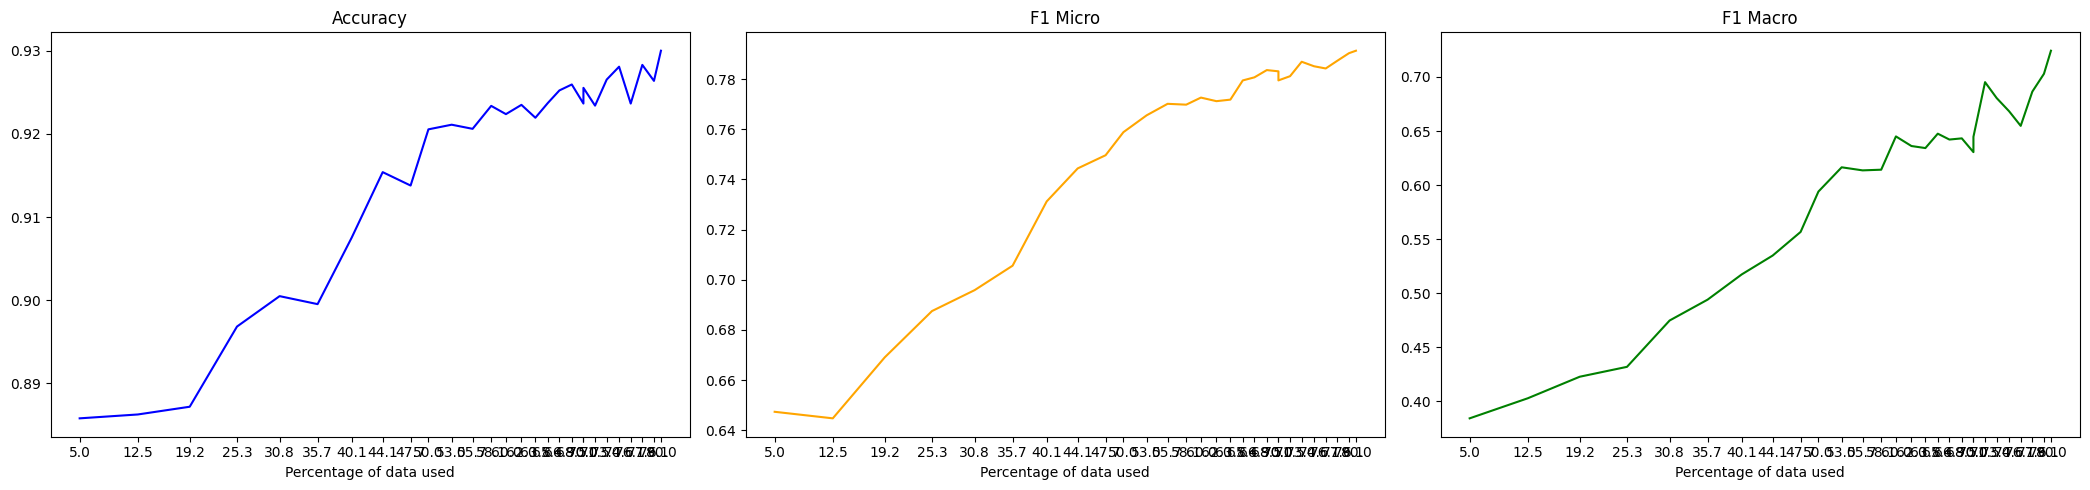

In [27]:
active_learning(seeds[4], 4)